In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as patches

import anndata as ad
import scanpy as sc
from cyvcf2 import VCF
from pyfaidx import Fasta
from Bio.Seq import reverse_complement
from Bio.Seq import Seq
from SigProfilerAssignment import Analyzer as Analyze

from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hypergeom
from scipy import stats
from scipy.sparse import vstack

from ete3 import Tree
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
from skbio.tree import nj, upgma, gme, bme, nni, majority_rule
from skbio import TreeNode
from skbio import DistanceMatrix
import dendropy
import baltic as bt
from io import StringIO
import pyranges as pr

import re
import os
from pathlib import Path
from itertools import product, combinations
from collections import Counter
from tqdm import tqdm

%matplotlib inline

In [2]:
pal = {
    'P_0': '#5AAA46',
    'P_1': '#F2B342',
    'P_2': '#C03830',
    'P_3': '#C43E96',
    'P_4': '#825CA6',
    'P_5': '#317EC2',
    'WT':'black'
}

In [3]:
adata = ad.read_h5ad('../results/K562_tree/K562_tree.h5ad')
adata

AnnData object with n_obs × n_vars = 1617 × 18646936
    layers: 'AD', 'DP'

# add sub-population metadata

In [4]:
obs = {}
for cell in adata.obs_names.to_list():
    if 'CTGTGAAC' in cell or 'ACATCGTC' in cell or 'TTGGATGC' in cell or 'GTTACGGT' in cell:
        obs[cell]="P_0"
    elif 'TGGTCTCA' in cell or 'TCCAGGAT' in cell or 'CATACCGT' in cell or 'TTCCACTC' in cell:
        obs[cell]="P_1"
    elif 'GTGACTCT' in cell or 'GGCATCAA' in cell or 'AGATACCG' in cell or 'TTGATGGC' in cell:
        obs[cell]="P_2"
    elif 'CGACCTAT' in cell or 'TCCTCAAC' in cell or 'TTGACCAC' in cell or 'GATGGTCT' in cell:
        obs[cell]="P_3"
    elif 'CGGTAAGT' in cell or 'TGACAGTG' in cell or 'CACTGACA' in cell or 'GTCGGTAA' in cell:
        obs[cell]="P_4"
    elif 'GTAACCGA' in cell or 'GTCCGATT' in cell or 'GACAGCAT' in cell or 'CGGTTGAT' in cell:
        obs[cell]="P_5"
obs = pd.DataFrame.from_dict(obs, orient='index', columns=['pop'])
adata.obs = obs
adata.obs

,pop
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGGTCGGTAAA,P_4
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGTGGTCTCAA,P_1
AAGGCTTGAGGAAACGATGGACTCAGACACCAAAGGCGGTTGATA,P_5
AAGGCTTGAGGAAACTGCTCACTCAGAATGCCAAGGGTCGGTAAA,P_4
AAGGCTTGAGGAAACTGCTCACTCTGCTATGGAAGGTCCTCAACA,P_3
...,...
TGTGGTTGAGGATTCGGTAGACTCCGAACTTGAAGGCGGTTGATA,P_5
TGTGGTTGAGGATTCGGTAGACTCGCTGGATAAAGGGTCGGTAAA,P_4
TGTGGTTGAGGATTCGGTAGACTCGTGTGATGAAGGTCCTCAACA,P_3
TGTGGTTGAGGATTGGTAGCACTCTCTGCTTGAAGGGACAGCATA,P_5


# data filtering

### Filter out non-snps

In [5]:
var_series = pd.Series(adata.var_names, index=adata.var_names)

# allow hyphens anywhere in the prefix
alleles = var_series.str.extract(r'^.*-\d+-([ACGT]+)>([ACGT]+)$', expand=True, flags=re.IGNORECASE)
ref = alleles[0].str.upper()
alt = alleles[1].str.upper()

# require both groups present and both length == 1
is_snp = ref.notna() & alt.notna() & (ref.str.len() == 1) & (alt.str.len() == 1)

is_snp.sum(), is_snp.head(20)

(np.int64(14194381),
 HLA-A*11:77-3027-A>T     True
 chr10-18923-A>C          True
 chr10-19260-T>C          True
 chr10-19320-A>G          True
 chr10-19365-C>T          True
 chr10-19413-A>C          True
 chr10-19424-C>A          True
 chr10-20164-T>A          True
 chr10-20165-A>C          True
 chr10-20166-G>A          True
 chr10-20179-A>G          True
 chr10-20193-T>A          True
 chr10-20321-A>G          True
 chr10-20332-G>A          True
 chr10-20423-T>C          True
 chr10-20425-C>CT        False
 chr10-20426-A>G          True
 chr10-20451-G>C          True
 chr10-20512-A>G          True
 chr10-20553-A>T          True
 dtype: bool)

In [6]:
adata = adata[:, is_snp]
adata = adata.copy()
adata

AnnData object with n_obs × n_vars = 1617 × 14194381
    obs: 'pop'
    layers: 'AD', 'DP'

### Compute SNPs per cell

In [7]:
adata.obs['SNP_count_raw'] = np.ravel(adata.X.sum(axis=1))

In [8]:
adata.obs['SNP_count_raw'].mean()

np.float32(22558.664)

### Filter Cells with abberantly low or high SNP counts

In [9]:
selected_barcodes = (
    adata.obs
    .sort_values(by='SNP_count_raw', ascending=False)  # Step 1: sort
    .head(1000)                  # Step 2: take top 1000
    .index                       # get the barcodes (index)
)
selected_barcodes

Index(['CAACTTGCAGGAAGATGGTCACTCTCCAGTCTAAGGGTCGGTAAA',
       'GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA',
       'CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA',
       'GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA',
       'ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA',
       'CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA',
       'ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA',
       'CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA',
       'CGCTAGTTAGGAAACTGCTCACTCTCTGCTTGAAGGGTCGGTAAA',
       'ACTAACCGAGGAAGATGGTCACTCTCTGGAACAAGGGTCCGATTA',
       ...
       'CGGTAGAAAGGACGACATTCACTCCACCATCTAAGGTGGTCTCAA',
       'ACTAACCGAGGATACAGCAGACTCTATGCGACAAGGCACTGACAA',
       'ATCGACAGAGGATACAGCAGACTCACAGTAGCAAGGTGACAGTGA',
       'GGTTGATGAGGACTGCTCAAACTCAGGTCGTAAAGGTTGATGGCA',
       'GGTCTCATAGGACGACAAGAACTCAGCATTGGAAGGTGACAGTGA',
       'GTGAGACTAGGAAGACCGATACTCAGGTCGTAAAGGCTGTGAACA',
       'CAACCAACAGGAATGGTGTGACTCTCCAGTCTAAGGGGCATCAAA',
       'GTAATGCCAGGAGGAACCAAACTCTGCTA

### Compute VAF in Bulk

In [10]:
adata.var['tot_depth_bulk'] = np.ravel(adata.layers['DP'].sum(axis=0))
adata.var['alt_depth_bulk'] = np.ravel(adata.layers['AD'].sum(axis=0))

adata.var['bulk_VAF_raw'] = adata.var['alt_depth_bulk'] / adata.var['tot_depth_bulk'] 
adata.var

,tot_depth_bulk,alt_depth_bulk,bulk_VAF_raw
HLA-A*11:77-3027-A>T,2.0,2.0,1.000000
chr10-18923-A>C,5.0,2.0,0.400000
chr10-19260-T>C,5.0,4.0,0.800000
chr10-19320-A>G,9.0,8.0,0.888889
chr10-19365-C>T,5.0,4.0,0.800000
...,...,...,...
chrY-9964396-T>A,2.0,2.0,1.000000
chrY-9964407-G>A,2.0,2.0,1.000000
chrY-9964416-T>C,2.0,2.0,1.000000
chrY-9965010-A>T,2.0,2.0,1.000000


Text(0, 0.5, 'Count of Sites')

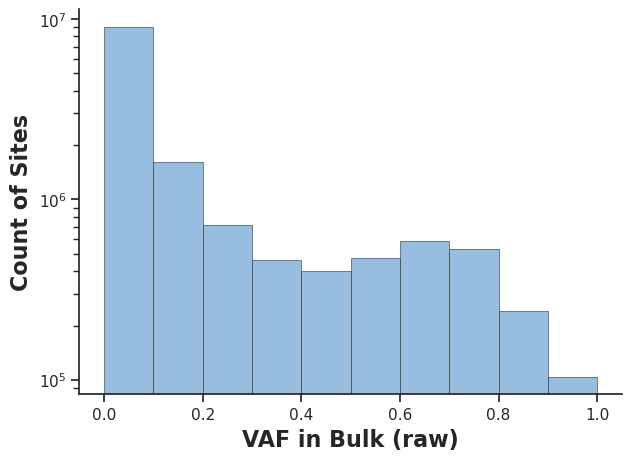

In [11]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='bulk_VAF_raw', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             # log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("VAF in Bulk (raw)", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

### Depth Histogram

Text(0, 0.5, 'Count of Sites')

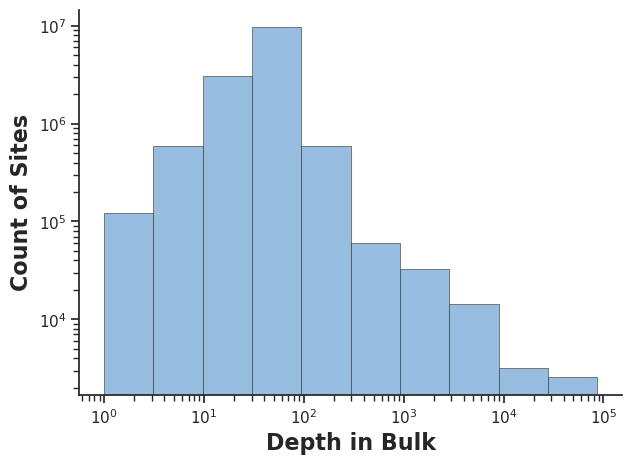

In [12]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='tot_depth_bulk', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("Depth in Bulk", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

### Filter Out Low Coverage Sites

In [13]:
good_coverage = adata.var['tot_depth_bulk']>=100

In [14]:
adata = adata[:, good_coverage].copy()
adata

AnnData object with n_obs × n_vars = 1617 × 566283
    obs: 'pop', 'SNP_count_raw'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw'
    layers: 'AD', 'DP'

### SNP Counts

In [15]:
## SNPs per cell
adata.obs['SNP_count'] = np.ravel(adata.X.sum(axis=1))

In [16]:
adata.obs['SNP_count'].mean()

np.float32(1459.4403)

In [17]:
## Total observed sites per cell
adata.obs['tot_observed_sites'] = np.ravel((adata.layers['DP']>0).sum(axis=1))

In [18]:
adata.obs['tot_observed_sites'].mean()

np.float64(59366.71614100185)

### Germline Variant Distribution and Filtering

first, count mitochondrial variants

In [19]:
mito_variants = [v for v in adata.var_names.tolist() if v.startswith('chrM')]

In [20]:
adata.obs['mito_snps'] = np.ravel(adata[:,adata.var_names.isin(mito_variants)].X.sum(axis=1))

In [21]:
adata.obs

,pop,SNP_count_raw,SNP_count,tot_observed_sites,mito_snps
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGGTCGGTAAA,P_4,41006.0,2742.0,102049,44.0
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGTGGTCTCAA,P_1,29576.0,1637.0,70973,46.0
AAGGCTTGAGGAAACGATGGACTCAGACACCAAAGGCGGTTGATA,P_5,38465.0,2172.0,81831,48.0
AAGGCTTGAGGAAACTGCTCACTCAGAATGCCAAGGGTCGGTAAA,P_4,41446.0,2788.0,102982,50.0
AAGGCTTGAGGAAACTGCTCACTCTGCTATGGAAGGTCCTCAACA,P_3,12602.0,828.0,37475,42.0
...,...,...,...,...,...
TGTGGTTGAGGATTCGGTAGACTCCGAACTTGAAGGCGGTTGATA,P_5,35916.0,2097.0,78064,42.0
TGTGGTTGAGGATTCGGTAGACTCGCTGGATAAAGGGTCGGTAAA,P_4,29767.0,2095.0,76406,42.0
TGTGGTTGAGGATTCGGTAGACTCGTGTGATGAAGGTCCTCAACA,P_3,8914.0,734.0,37118,41.0
TGTGGTTGAGGATTGGTAGCACTCTCTGCTTGAAGGGACAGCATA,P_5,18751.0,1115.0,46539,46.0


**Load K562 reference**

In [22]:
vcf_file = "../bin/ENCFF538YDL_hg38.vcf.gz"

vcf = VCF(vcf_file)

# First: load all variants into a list
K562_variants = list(vcf)

# Extract variant names from that
K562_variants = [f"{v.CHROM}-{v.start}-{v.REF}>{v.ALT[0]}" for v in K562_variants]
K562_variants = np.array(K562_variants)

del vcf

In [23]:
K562_set = set(K562_variants)  # ensure it's a set for O(1) lookup


In [24]:
# Convert Index to Series so we can use .str methods
K562_series = pd.Series(K562_variants)

# Split to get REF and ALT alleles
alleles = K562_series.str.extract(r'^[^-]+-\d+-([ACGT]+)>([ACGT]+)$', expand=True)
ref = alleles[0]
alt = alleles[1]

K562_is_snp = (ref.str.len() == 1) & (alt.str.len() == 1)
K562_snps = K562_series[K562_is_snp]

In [25]:
len(K562_snps)

3069185

In [26]:
K562_snps = np.array(K562_snps)

**Plot distribution**

In [27]:
adata.obs['germline_count'] = np.ravel(adata[:,adata.var_names.isin(K562_snps)].X.sum(axis=1))

In [28]:
adata.obs['germline_count'].mean()

np.float32(586.81384)

**Filtering**

In [29]:
non_germline = ~adata.var_names.isin(K562_snps)

In [30]:
adata = adata[:, non_germline].copy()
adata

AnnData object with n_obs × n_vars = 1617 × 527638
    obs: 'pop', 'SNP_count_raw', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw'
    layers: 'AD', 'DP'

In [31]:
adata.obs['SNP_count_de_novo'] = np.ravel(adata.X.sum(axis=1))

In [32]:
adata.obs['SNP_count_de_novo'].mean()

np.float32(872.62646)

### Corrected VAF

In [33]:
def downsample_vaf(ad, dp, target_dp=10):
    ad = ad.astype(int)
    dp = dp.astype(int)
    downsampled_ad = np.where(
        dp > target_dp,
        hypergeom.rvs(dp, ad, target_dp),  # Downsample AD
        ad  # Keep AD as is if DP <= target_dp
    )
    downsampled_dp = np.minimum(dp, target_dp)
    return downsampled_ad / downsampled_dp


In [34]:
adata.var['bulk_VAF_cor'] = downsample_vaf(adata.var['alt_depth_bulk'], adata.var['tot_depth_bulk'], target_dp=100)

Text(0, 0.5, 'Count of Sites')

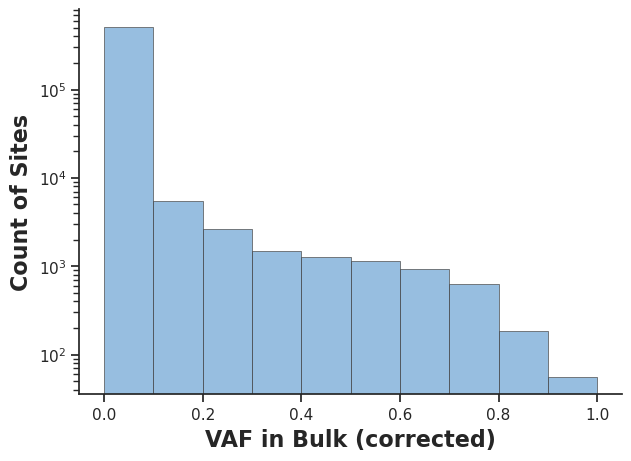

In [35]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='bulk_VAF_cor', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             # log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("VAF in Bulk (corrected)", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

### Save adata

In [36]:
adata.write_h5ad("../results/K562_tree/K562_tree_cleaned.h5ad")

... storing 'pop' as categorical


In [102]:
adata = sc.read_h5ad("../results/K562_tree/K562_tree_cleaned.h5ad")
adata

AnnData object with n_obs × n_vars = 1617 × 527638
    obs: 'pop', 'SNP_count_raw', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor'
    layers: 'AD', 'DP'

# Metrics

**Count of Singletons**

In [54]:
adata.obs['SNP_count_de_novo_high_quality'] = np.ravel(adata.X.sum(axis=1))

**cells per variant**

In [55]:
adata.var['count_of_cells'] = np.ravel(adata.X.sum(axis=0))

**Sub-pop metrics**

In [56]:
pops = [f'P_{i}' for i in range(0,6)]
pops

['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']

In [57]:
pop_sizes = {pop : len(adata.obs[adata.obs['pop']==pop]) for pop in pops}
pop_sizes = pd.DataFrame.from_dict(pop_sizes, orient='index', columns = ['count'])
pop_sizes = pop_sizes.reset_index().rename(columns={'index': 'population'})
pop_sizes

,population,count
0,P_0,251
1,P_1,180
2,P_2,407
3,P_3,335
4,P_4,290
5,P_5,154


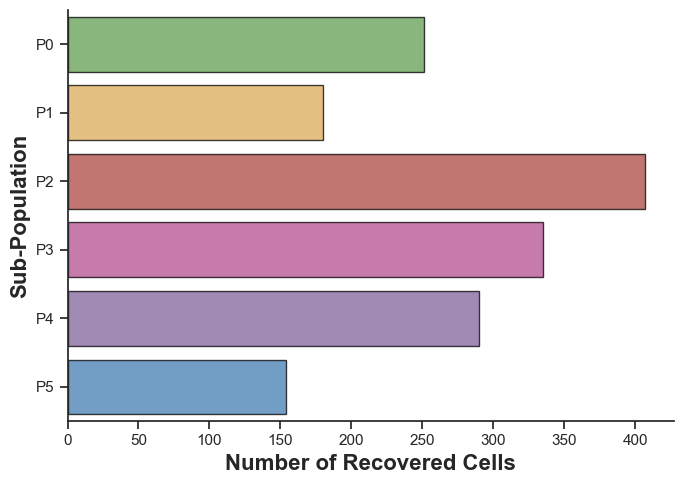

In [58]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(
    data=pop_sizes,
    y='population',
    x='count',
    palette=pal,
    alpha=0.75,
    edgecolor="black",
    linewidth=1,
)
plt.xlabel('Number of Recovered Cells', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)
new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_yticklabels(new_labels)
plt.tight_layout()
# f.savefig('../results/K562_tree/cells_per_subpop.png', dpi=600, bbox_inches='tight')

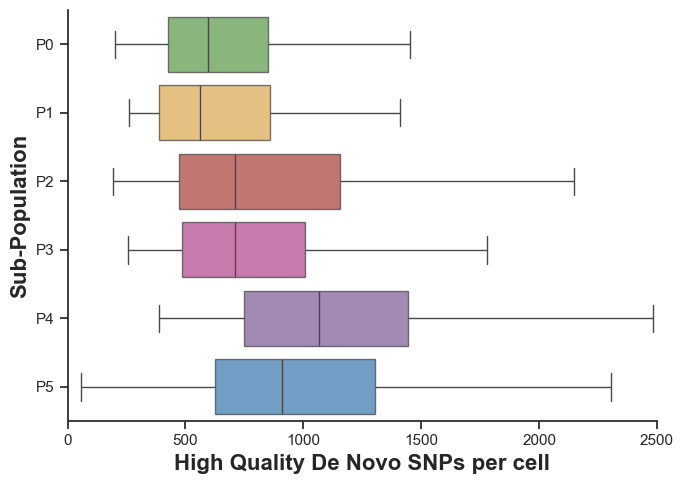

In [59]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(
    data=adata.obs,
    y='pop',
    x='SNP_count_de_novo',
    palette=pal,
    fliersize=0 
)
# ax.set_xscale('log')
for patch in ax.patches:
    patch.set_alpha(0.75) 
plt.xlim(0,2500)
plt.xlabel('High Quality De Novo SNPs per cell', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)

new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_yticklabels(new_labels)

plt.tight_layout()
# f.savefig('../results/K562_tree/SNPs_per_cell.png', dpi=600, bbox_inches='tight')

In [60]:
adata.obs.to_csv('../results/K562_tree/meta.csv')

In [61]:
pop_sizes.to_csv('../results/K562_tree/pop_sizes.csv')

In [62]:
adata.var.to_csv('../results/K562_tree/bulk_vaf.csv')

### Grouped VAF

In [63]:
min_DP = 50
num_bins = 10
bin_edges = np.linspace(0, 1, num_bins + 1) 

histograms = {pop: np.zeros(num_bins, dtype=int) for pop in pops}

for pop in pops:
    subset = adata[adata.obs['pop'] == pop].copy()
    AD = np.ravel(subset.layers['AD'].sum(axis=0)).astype(int)
    DP = np.ravel(subset.layers['DP'].sum(axis=0)).astype(int)

    # Filters
    mask = (DP > min_DP) & (AD > 1) & (AD != DP)
    AD = AD[mask]
    DP = DP[mask]

    VAF = downsample_vaf(AD, DP, min_DP)  # min_DP still controls downsampling depth

    bin_idx = np.digitize(VAF, bin_edges) - 1
    for idx in bin_idx:
        if 0 <= idx < num_bins:
            histograms[pop][idx] += 1

group_VAF = pd.DataFrame.from_dict(histograms, orient="index", columns=[f"bin_{i}" for i in range(num_bins)])

# group_VAF

In [64]:
group_VAF['pop'] = pops
df_melted = group_VAF.melt(id_vars=["pop"], var_name="bin")
df_melted["bin"] = df_melted["bin"].str.extract("(\d+)").astype(int)
# df_melted

INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


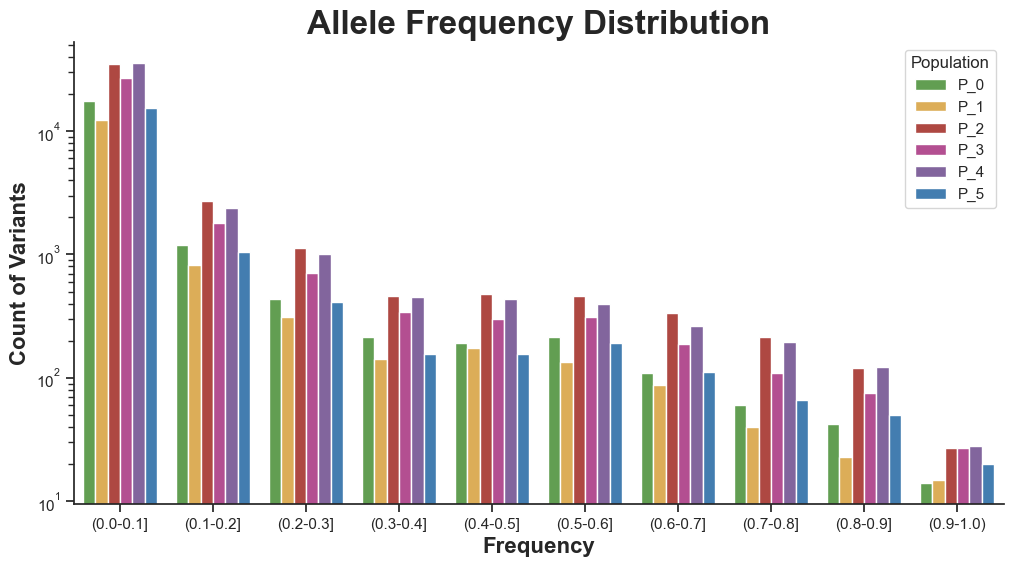

In [65]:
fig,ax = plt.subplots(1,1,figsize=(12, 6))
sns.barplot(data=df_melted, x="bin", y="value", hue="pop", palette=pal, errorbar=None, ax = ax)
plt.xlabel("Frequency", fontweight='bold', fontsize=16)
plt.ylabel("Count of Variants", fontweight='bold', fontsize=16)
plt.title("Allele Frequency Distribution", fontweight='bold', fontsize=24)
plt.legend(title="Population")
# Define bin labels
bin_edges = np.linspace(0, 1, 11)  # If min_DP = 10, 11 edges
bin_labels = [f"({bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}]" for i in range(len(bin_edges)-2)]
bin_labels.append("(0.9-1.0)")
plt.xticks(ticks=np.arange(len(bin_labels)), labels=bin_labels, rotation=0)
sns.despine()
ax.set_yscale('log')
fig.savefig('../results/K562_tree/grouped_allele_freq.png')

In [66]:
group_VAF.to_csv('../results/K562_tree/group_VAF.csv')

# Trinucleotide spectra

In [103]:
# === 1. Helper: reverse complement ===
def reverse_complement(seq: str) -> str:
    return str(Seq(seq).reverse_complement())

# === 2. Standardize to pyrimidine-based trinucleotide ===
def strand_standardize_trinuc(ref_trinuc: str, alt_base: str) -> str:
    """
    Converts a trinucleotide substitution into pyrimidine-based form (per COSMIC convention).
    If the central base is a purine (A/G), reverse complements both the trinucleotide and alt.
    Returns standardized 3mer substitution string (e.g. 'TCG>TTG').
    """
    if ref_trinuc[1] in "AG":
        trinuc_rc = reverse_complement(ref_trinuc)
        alt_rc = reverse_complement(alt_base)
        return f"{trinuc_rc}>{trinuc_rc[0]}{alt_rc}{trinuc_rc[2]}"
    else:
        return f"{ref_trinuc}>{ref_trinuc[0]}{alt_base}{ref_trinuc[2]}"

# === 3. Add standardized trinuc contexts to adata.var ===
def add_trinuc_context(adata, fasta_path, chrom_prefix="chr"):
    """
    Annotate adata.var with ancestral and derived trinucleotide contexts and
    standardized COSMIC 96-type labels.
    Assumes adata.var_names look like 'chr1-12345-A>T'.
    """
    ref = Fasta(fasta_path, sequence_always_upper=True)
    ancs, ders, types = [], [], []

    for variant in tqdm(adata.var_names, desc="Annotating trinuc contexts"):
        match = re.match(rf"({chrom_prefix}[\w]+)-(\d+)-([ACGT])>([ACGT])", variant)
        if not match:
            ancs.append(np.nan)
            ders.append(np.nan)
            types.append(np.nan)
            continue

        chrom, pos, ref_base, alt_base = match.groups()
        pos = int(pos)

        # Extract 3-mer centered on variant
        anc_trinuc = ref[chrom][pos - 1 : pos + 2].seq
        der_trinuc = anc_trinuc[0] + alt_base + anc_trinuc[2]
        trinuc_type = strand_standardize_trinuc(anc_trinuc, alt_base)

        ancs.append(anc_trinuc)
        ders.append(der_trinuc)
        types.append(trinuc_type)

    adata.var["anc"] = ancs
    adata.var["der"] = ders
    adata.var["trinuc_type"] = types
    return adata

# === 4. Canonical 96-context order ===
def get_canonical_96_order():
    bases = ["A", "C", "G", "T"]
    substitutions = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
    contexts = []
    for sub in substitutions:
        ref_from, ref_to = sub.split(">")
        for b1 in bases:
            for b3 in bases:
                contexts.append(f"{b1}{ref_from}{b3}>{b1}{ref_to}{b3}")
    return contexts

# --- Bulk (variant occurrences across cells) and per-cell spectra ---
def compute_bulk_and_percell_spectra(adata, trinuc_col="trinuc_type", add_trinuc_if_missing=True):
    """
    Returns:
      bulk_series: pd.Series indexed by canonical 96 contexts (counts across all cells)
      percell_df: pd.DataFrame (cells x 96) with counts per cell (sparse-backed DataFrame)
    Side-effect: does not modify adata unless you want to attach percell_df to adata.obs.
    """
    # 0) ensure trinuc_type exists
    if trinuc_col not in adata.var.columns:
        if add_trinuc_if_missing:
            # assumes you have add_trinuc_context(adata, fasta_path) defined elsewhere
            raise RuntimeError(f".var lacks '{trinuc_col}'. Run add_trinuc_context() first.")
        else:
            raise RuntimeError(f".var lacks '{trinuc_col}' and add_trinuc_if_missing=False")

    canonical = get_canonical_96_order()

    # 1) get per-variant total across cells (works with sparse .X)
    variant_counts = np.asarray(adata.X.sum(axis=0)).ravel()    # length = n_vars

    # 2) get variant-level trinuc types aligned to adata.var order
    var_trinuc = pd.Series(adata.var[trinuc_col].astype(str).values, index=adata.var_names)

    # 3) Bulk spectrum: sum counts grouped by trinuc type
    mut_df = pd.DataFrame({
        "trinuc": var_trinuc.values,
        "count": variant_counts
    }, index=adata.var_names)

    bulk = mut_df.groupby("trinuc")["count"].sum().reindex(canonical, fill_value=0)
    bulk = bulk.astype(int)

    # 4) Per-cell spectra:
    # Build a mapping from trinuc -> column index in canonical order (only include present contexts)
    present_trinucs = np.array([t for t in canonical if t in var_trinuc.values])
    mapping = {t: i for i, t in enumerate(present_trinucs)}

    # If you want the full 96 columns in a fixed order, we'll build one_hot with shape (n_vars, len(canonical))
    # but to be memory-efficient we can map to present_trinucs then reindex to canonical later.
    n_vars = adata.n_vars
    rows = np.arange(n_vars, dtype=int)
    # map each variant's trinuc to index in present_trinucs
    cols = np.array([mapping.get(t, -1) for t in var_trinuc.values], dtype=int)
    if (cols == -1).any():
        # should not happen because we built present_trinucs from var_trinuc.values, but check defensively
        raise RuntimeError("Some variant trinuc values not found in mapping")

    data = np.ones(n_vars, dtype=int)
    one_hot_present = csr_matrix((data, (rows, cols)), shape=(n_vars, len(present_trinucs)), dtype=int)

    # Multiply: (cells x variants) dot (variants x present_trinucs) -> (cells x present_trinucs)
    percell_present = adata.X.dot(one_hot_present)  # sparse matrix

    # Convert to DataFrame.sparse and then reindex columns to canonical 96 with zeros for missing contexts
    percell_df_present = pd.DataFrame.sparse.from_spmatrix(percell_present,
                                                           index=adata.obs_names,
                                                           columns=present_trinucs)
    # Reindex to canonical full order
    percell_df = percell_df_present.reindex(columns=canonical, fill_value=0).astype("Int64")  # nullable ints

    # 5) Sanity checks: sum totals must match
    total_X = int(adata.X.sum())
    total_bulk = int(bulk.sum())
    total_percell = int(percell_df.to_numpy().sum())
    if total_X != total_bulk:
        raise AssertionError(f"Mismatch: total occurrences from adata.X ({total_X}) != bulk ({total_bulk})")
    if total_X != total_percell:
        raise AssertionError(f"Mismatch: total occurrences from adata.X ({total_X}) != per-cell sum ({total_percell})")

    return bulk, percell_df

# === 6. Plotting ===
def plot_spectra(spectra, name=None, outpath=None):
    """
    Plot 96-channel mutation spectra (C>A, C>G, C>T, T>A, T>C, T>G)
    Compatible with your existing data and aesthetics.

    Parameters
    ----------
    spectra : pd.Series or pd.DataFrame
        - If Series: index are 96 mutation contexts (e.g., 'TCA>TTA'), values are counts
        - If DataFrame: same as before (single-row DataFrame)
    name : str, optional
        Title for the plot
    outpath : str, optional
        Save path for the figure
    """

    # --- Accept Series or DataFrame ---
    if isinstance(spectra, pd.Series):
        spectra = spectra.to_frame().T  # convert to 1-row DataFrame
    
    titles = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    mut_types = {t: [] for t in titles}

    for mut in spectra.columns.to_list():
        if mut[1] == 'C' and mut[-2] == 'A':
            mut_types['C>A'].append(mut)
        elif mut[1] == 'C' and mut[-2] == 'G':
            mut_types['C>G'].append(mut)
        elif mut[1] == 'C' and mut[-2] == 'T':
            mut_types['C>T'].append(mut)
        elif mut[1] == 'T' and mut[-2] == 'A':
            mut_types['T>A'].append(mut)
        elif mut[1] == 'T' and mut[-2] == 'C':
            mut_types['T>C'].append(mut)
        elif mut[1] == 'T' and mut[-2] == 'G':
            mut_types['T>G'].append(mut)

    hex_cols = [
        '#438CFD', '#01182E', '#ff1A5E', '#E6E6E6', '#80F15D', '#FFDB58'
    ]

    data = spectra.iloc[0]
    fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharey=True, gridspec_kw={'wspace': 0})
    for i, ax in enumerate(axes):
        x = mut_types[titles[i]]
        ax.bar(x, data[x], color=hex_cols[i])
        ax.set_title(f"{titles[i]}", fontweight='bold', fontsize=16)
        ax.set_xticklabels(x, rotation=90)

        rect = patches.Rectangle(
            (0.01, 0.95), 0.98, 0.05,
            transform=ax.transAxes,
            color=hex_cols[i],
            clip_on=False
        )
        ax.add_patch(rect)
        ax.spines["top"].set_visible(False)
        ax.set_ylim(0, max(data) * 1.1)
        if i == 0:
            ax.set_ylabel("Mutations", fontweight='bold', fontsize=16)
        else:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)

    if name:
        fig.suptitle(name, fontweight='bold', fontsize=20)
    if outpath:
        fig.savefig(outpath, dpi=600, bbox_inches='tight')
    else:
        plt.show()

In [104]:
def reformat_mut_type(mut):
    return f"{mut[0]}[{mut[1]}>{mut[-2]}]{mut[-1]}"

Annotating trinuc contexts: 100%|██████████| 527638/527638 [00:06<00:00, 83432.58it/s]


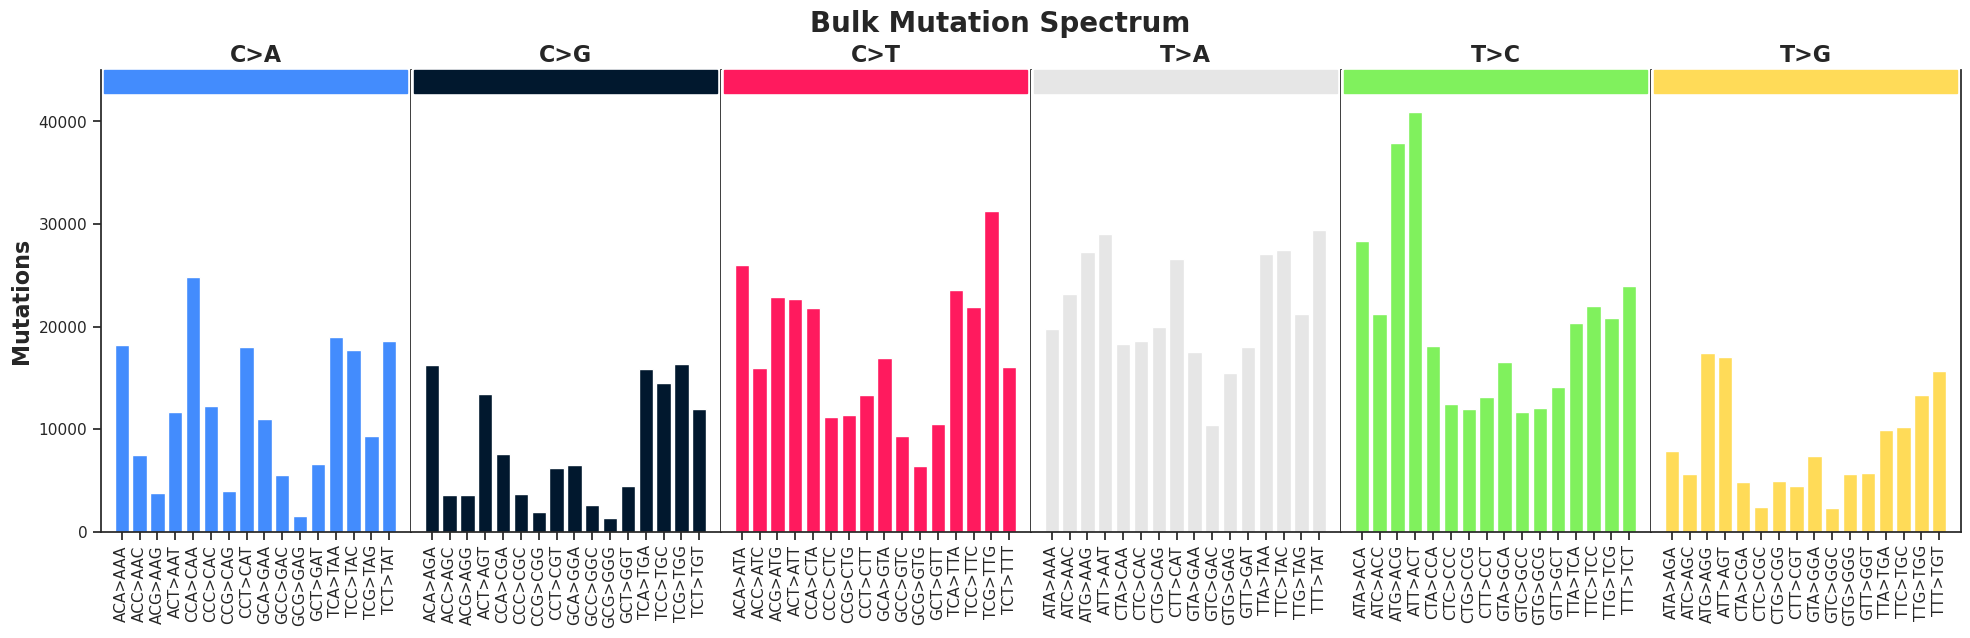

In [105]:
# Path to reference FASTA
fasta = "/shared/biodata/reference/GATK/hg38/Homo_sapiens_assembly38.fasta"

# Step 1 — annotate trinucleotide contexts
adata = add_trinuc_context(adata, fasta)

# Step 2 — 
bulk, percell = compute_bulk_and_percell_spectra(adata, trinuc_col="trinuc_type")

# Step 3 — plot bulk spectrum (sum over all cells)
plot_spectra(bulk, name="Bulk Mutation Spectrum")

# Save to CSV
# bulk_spectra.to_csv("../results/K562_tree/bulk_spectra.csv")

In [106]:
print("n_vars:", adata.n_vars)
print("n_cells:", adata.n_obs)
print("sum of adata.X (total mutation occurrences):", int(adata.X.sum()))
print("sum spectra:", int(bulk.sum()))


n_vars: 527638
n_cells: 1617
sum of adata.X (total mutation occurrences): 1411037
sum spectra: 1411037


In [107]:
bulk.index = [reformat_mut_type(mut) for mut in bulk.index.to_list()]
bulk.to_frame().to_csv('../results/K562_tree/bulk_spectra.txt', sep='\t')

### Bulk Spectra (No singletons)

In [108]:
mask = (np.ravel(adata.X.sum(axis=0))>1)
adata = adata[:,mask].copy()
adata

AnnData object with n_obs × n_vars = 1617 × 86344
    obs: 'pop', 'SNP_count_raw', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor', 'anc', 'der', 'trinuc_type'
    layers: 'AD', 'DP'

Annotating trinuc contexts: 100%|██████████| 86344/86344 [00:01<00:00, 79401.14it/s]


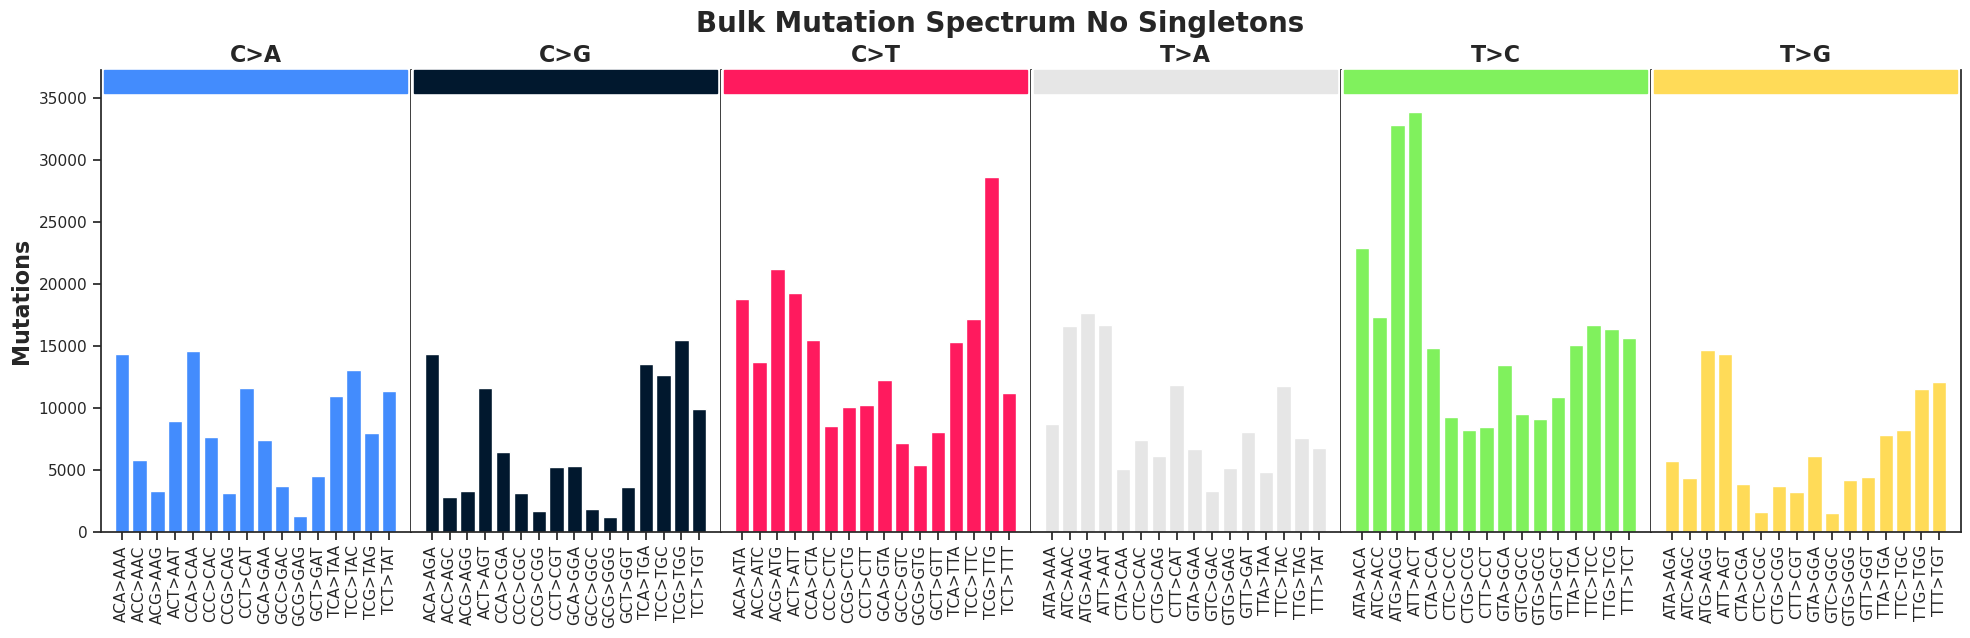

In [113]:
# Path to reference FASTA
fasta = "/shared/biodata/reference/GATK/hg38/Homo_sapiens_assembly38.fasta"

# Step 1 — annotate trinucleotide contexts
adata = add_trinuc_context(adata, fasta)

# Step 2 — 
bulk_ns, percell_ns = compute_bulk_and_percell_spectra(adata, trinuc_col="trinuc_type")

# Step 3 — plot bulk spectrum (sum over all cells)
plot_spectra(bulk_ns, name="Bulk Mutation Spectrum No Singletons")

# Save to CSV
# bulk_spectra.to_csv("../results/K562_tree/bulk_spectra.csv")

In [114]:
print("n_vars:", adata.n_vars)
print("n_cells:", adata.n_obs)
print("sum of adata.X (total mutation occurrences):", int(adata.X.sum()))
print("sum spectra:", int(bulk_ns.sum()))


n_vars: 86344
n_cells: 1617
sum of adata.X (total mutation occurrences): 969757
sum spectra: 969757


In [115]:
bulk_ns.to_frame()
#.index#'trinuc']

,count
trinuc,
ACA>AAA,14318
ACC>AAC,5835
ACG>AAG,3273
ACT>AAT,8905
CCA>CAA,14570
...,...
GTT>GGT,4433
TTA>TGA,7846
TTC>TGC,8233


In [112]:
bulk_ns.index = [reformat_mut_type(mut) for mut in bulk_ns.index.to_list()]
bulk_ns.to_frame().to_csv('../results/K562_tree/bulk_spectra_ns.txt', sep='\t')

# Signature Decomposition

In [117]:
Analyze.cosmic_fit('../results/K562_tree/bulk_spectra_ns.txt', '../results/K562_tree/', 
                   input_type="matrix",
                   context_type="96",
                   collapse_to_SBS96=False,
                   cosmic_version=3.4,
                   exome=False,
                   genome_build="GRCh38",
                   make_plots=True,
                   sample_reconstruction_plots=False,
                   verbose=True,
                   nnls_add_penalty=0.0,      # allow addition with no penalty
                   nnls_remove_penalty=0.0,   # don't force removals
                   initial_remove_penalty=0.0,
                   cpu=1,
                   add_background_signatures=True
                  )

Assigning COSMIC sigs or Signature Database ...... 





                                        ################ Sample 1 #################
############################# Initial Composition #################################### 
      SBS1  SBS2  SBS3  SBS4      SBS5  SBS6   SBS7a  SBS7b  SBS7c  SBS7d  \
0  21694.0   0.0   0.0   0.0  163554.0   0.0  8418.0    0.0    0.0    0.0   

   ...  SBS90  SBS91  SBS92  SBS93  SBS94  SBS95     SBS96   SBS97    SBS98  \
0  ...    0.0    0.0    0.0    0.0    0.0    0.0  166067.0  7137.0  33414.0   

    SBS99  
0  6855.0  

[1 rows x 86 columns]
L2%:  0.30067542916262074
############################## Composition After Initial Remove ############################### 
      SBS1  SBS2  SBS3  SBS4      SBS5  SBS6   SBS7a  SBS7b  SBS7c  SBS7d  \
0  21694.0   0.0   0.0   0.0  163554.0   0.0  8418.0    0.0    0.0    0.0   

   ...  SBS90  SBS91  SBS92  SBS93  SBS94  SBS95     SBS96   SBS97    SBS98  \
0  ...    0.0    0.0    0.0    0.0    0.0    0.0  166

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished




 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


# Examine sub population spectra

In [127]:
pops = [f'P_{i}' for i in range(0,6)]
pops

['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']

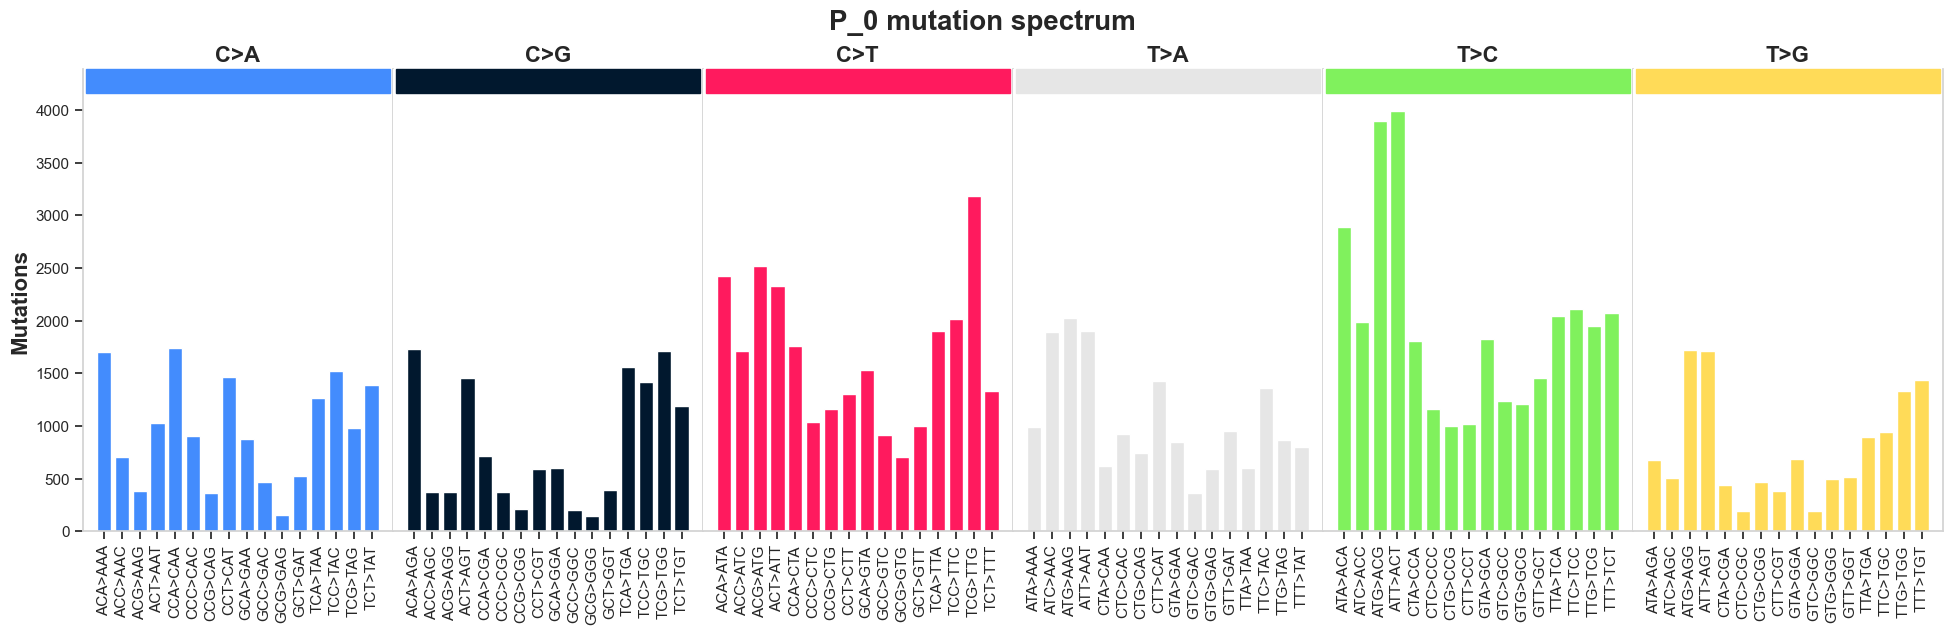

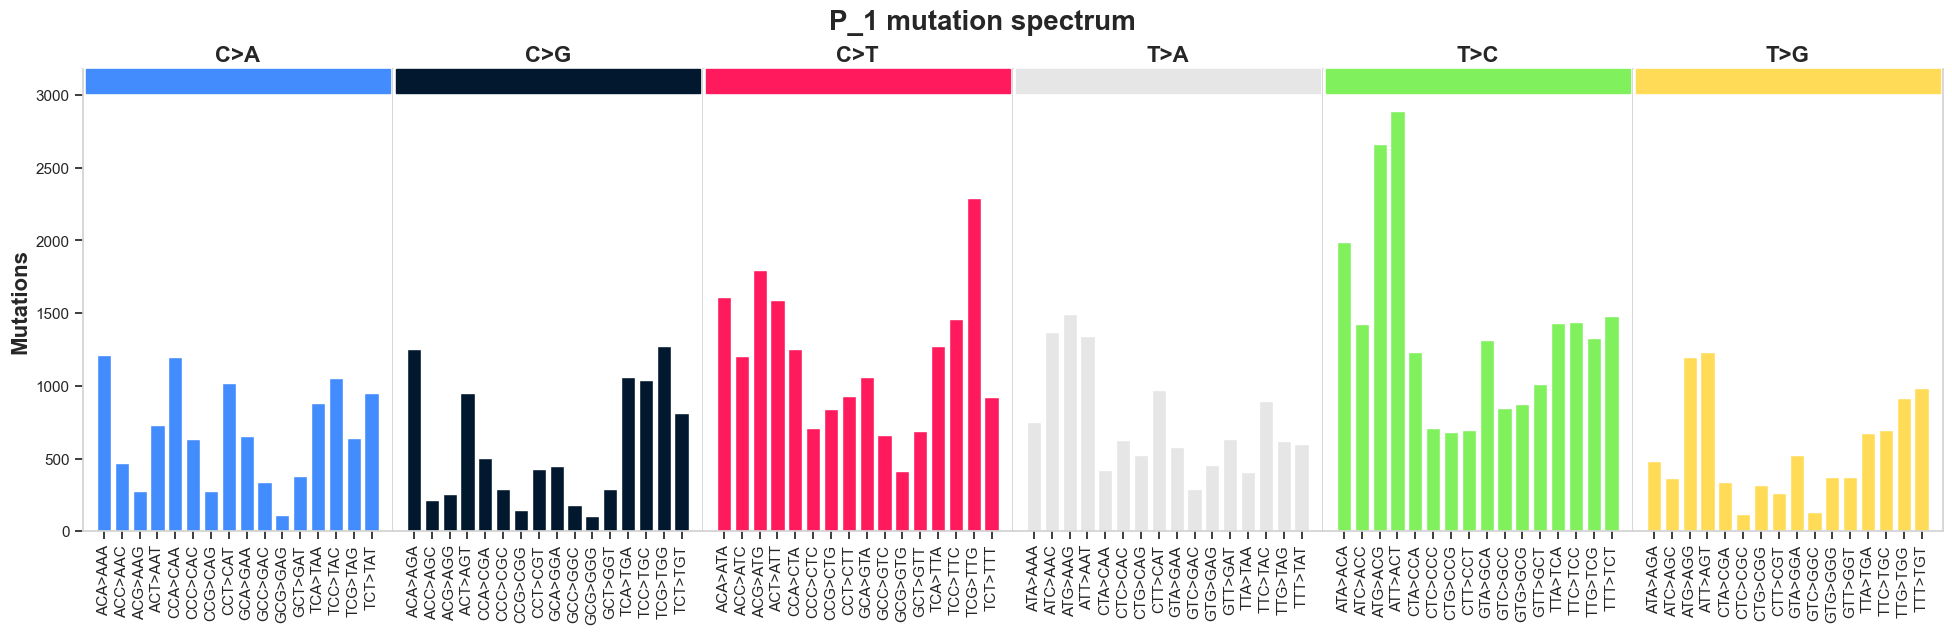

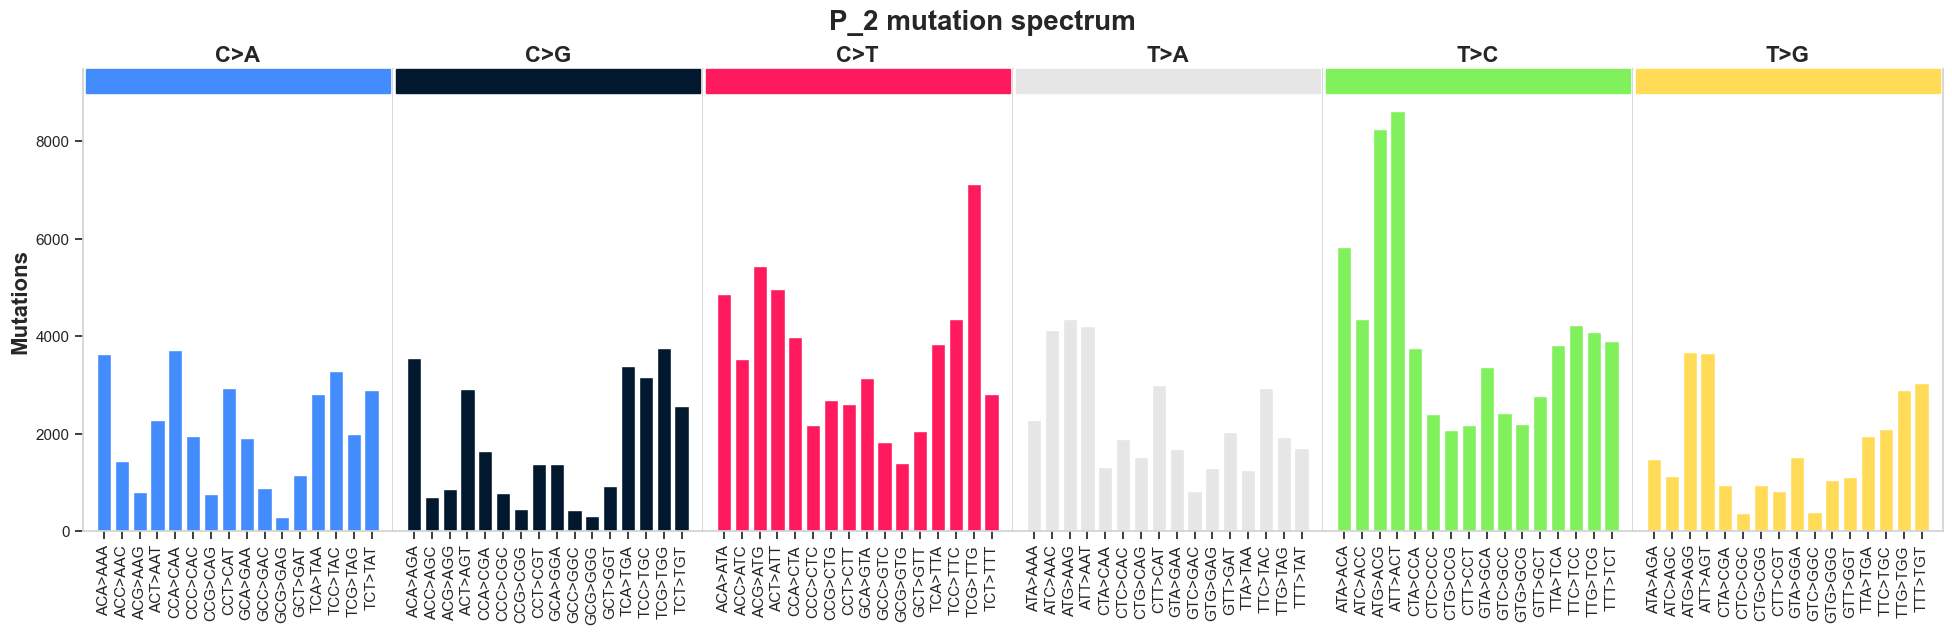

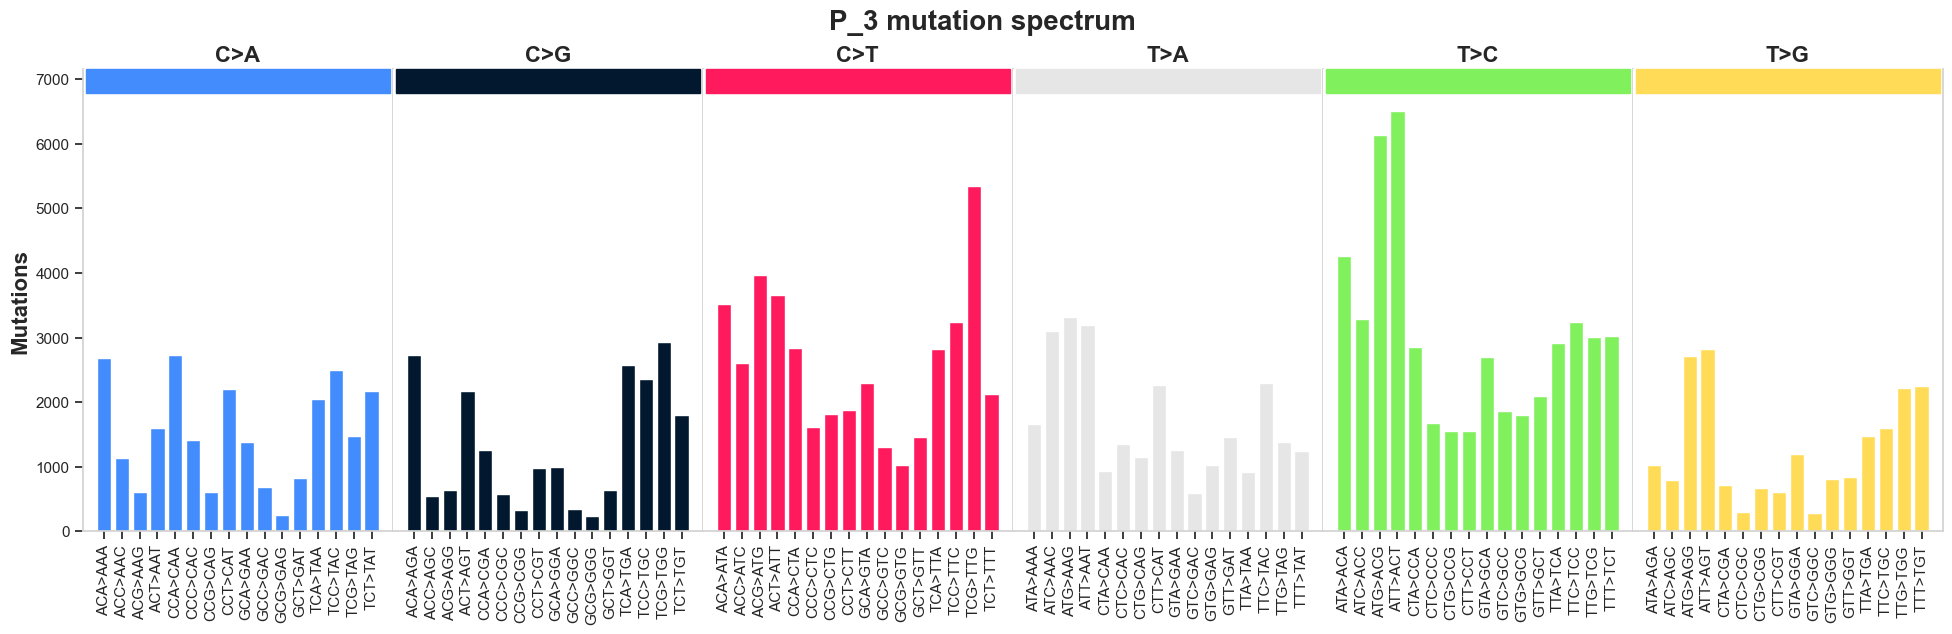

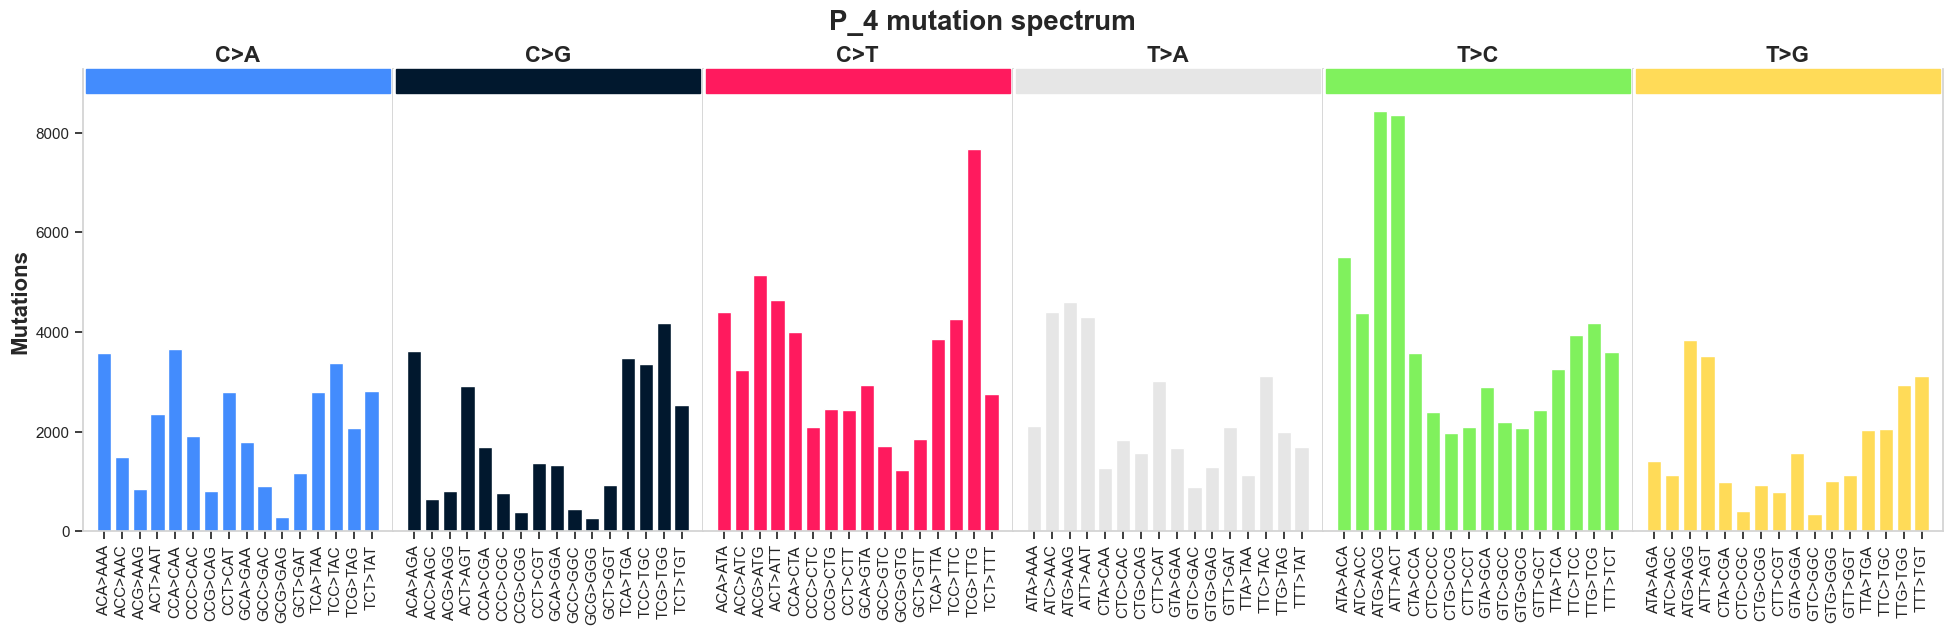

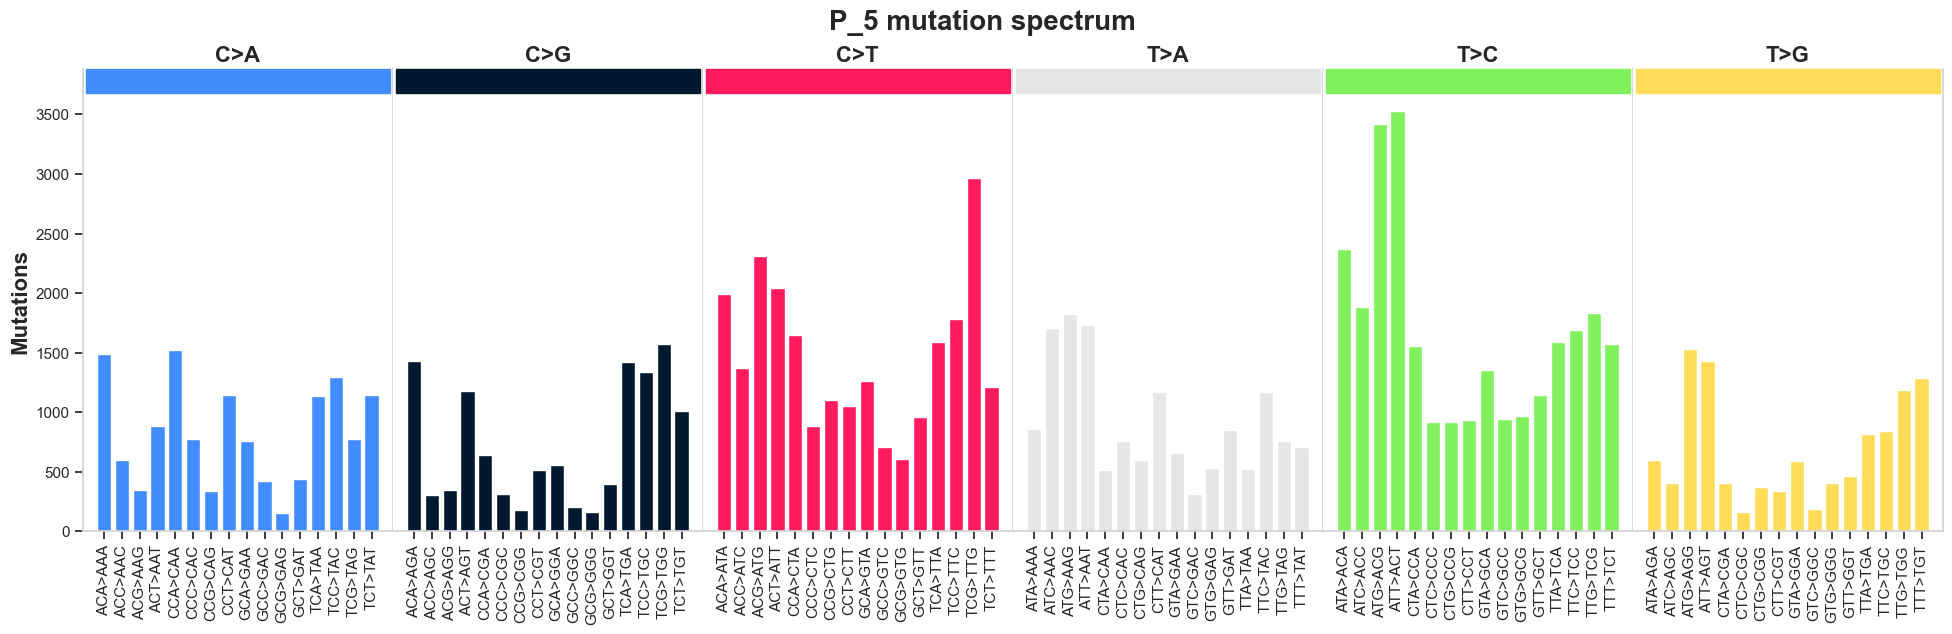

In [128]:
for pop in pops:
    spectra = percell_ns.loc[adata.obs[adata.obs['pop']==pop].index].sum()
    plot_spectra(spectra, name=f"{pop} mutation spectrum")


In [129]:
percell_ns.to_csv('../results/K562_tree/per_cell_spectra_ns.csv')

### Save h5 for downstream analysis

In [52]:
adata.write_h5ad("../results/K562_tree/K562_tree_cleaned_ns.h5ad")

... storing 'anc' as categorical
... storing 'der' as categorical
... storing 'type' as categorical


### Load Anndata

In [359]:
adata = sc.read_h5ad('../results/K562_tree/K562_tree_cleaned_ns.h5ad')

# Tree Construction

In [342]:
adata = sc.read_h5ad('../results/K562_tree/K562_tree_cleaned_ns.h5ad')

# keep = adata.var['tot_depth_bulk']>=1000
# keep = (adata.var['bulk_VAF_cor']>0) & (adata.var['bulk_VAF_cor']<0.4) & (adata.var['tot_depth_bulk']>=1000)
# adata = adata[:, keep].copy()

# # minimize quantity of missing data
# X_csc = adata.layers['DP'].tocsc()

# # Count nonzeros per column
# nonzeros_per_col = np.diff(X_csc.indptr)
# cols_to_keep = np.where(nonzeros_per_col >= 1500)[0]
# adata = adata[:, cols_to_keep].copy()

# keep = adata.var['type']=='TCG>TTG'
# adata = adata[:, keep].copy()

adata

AnnData object with n_obs × n_vars = 1617 × 86344
    obs: 'pop', 'SNP_count_raw', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor', 'anc', 'der', 'type'
    layers: 'AD', 'DP'

In [343]:
pops = [f'P_{i}' for i in range(0,6)]
pops

['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']

### Create list of informative features

- only those shared by all cells within a subpop ❌

- top observed features accross all cells? 

- top observed features within each subpop?

In [344]:
## Odds ratio

n_features = 1000
pop_features = {}
ordered_pops = ['P_5', 'P_4', 'P_3', 'P_2', 'P_1', 'P_0']

features = []
top_all = pd.Series(np.ravel(adata.X.sum(axis=0)), index=adata.var_names).sort_values(ascending=False)[:n_features].index.to_list()
features += top_all
for i, pop in enumerate(ordered_pops):
    pop_cells = adata[adata.obs['pop'] == pop, ~adata.var_names.isin(top_all)]
    pop_X = pop_cells.X
    
    count_with = np.ravel(pop_X.sum(axis=0))
    count_without = pop_cells.n_obs - count_with
    
    # pop_frac = np.ravel(pop_X.sum(axis=0)) / pop_X.shape[0]
    # pop_frac_series = pd.Series(pop_frac, index=adata.var_names)
    
    # pop_frac_series.drop(labels=top_all, errors='ignore')
    
    # top = enrichment.sort_values(ascending=False)[:n_features].index.to_list()
    
    if i == 0:
        # No previous populations to compare against
        count_with_series = pd.Series(count_with, index=pop_cells.var_names)
        top = count_with_series.sort_values(ascending=False)[:n_features].index.to_list()
    else:
        # Combine all previous subpopulations
        prev_pops = ordered_pops[:i]
        prev_cells = adata[adata.obs['pop'].isin(prev_pops), ~adata.var_names.isin(top_all)]
        prev_X = prev_cells.X
        
        prev_count_with = np.ravel(prev_X.sum(axis=0))
        prev_count_without = prev_cells.n_obs - prev_count_with
        
        # Apply 0.5 continuity correction to avoid division by zero
        a = count_with + 0.5
        b = count_without + 0.5
        c = prev_count_with + 0.5
        d = prev_count_without + 0.5

        # Compute odds ratios vectorized
        odds_ratios = (a * d) / (b * c)
        odds_ratios_series = pd.Series(odds_ratios, index=pop_cells.var_names)

        # Rank features most enriched in this population
        top = odds_ratios_series.sort_values(ascending=False)[:n_features].index.to_list()
    
    pop_features[pop] = top
    features += top

In [345]:
for pop in ordered_pops:
    adata.obs[f'{pop} Features'] = np.ravel(adata[:,adata.var_names.isin(pop_features[pop])].X.sum(axis=1))
# adata.obs

In [346]:
df_long = adata.obs.reset_index().melt(
    id_vars='pop',  # the grouping column
    value_vars=['P_5 Features', 'P_4 Features', 'P_3 Features', 'P_2 Features', 'P_1 Features', 'P_0 Features'],  # your variant sets
    var_name='feature_set',
    value_name='count'
)

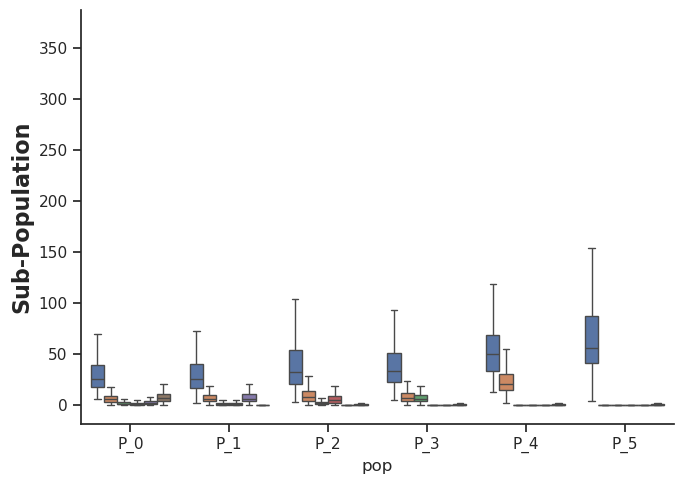

In [347]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(data=df_long, x='pop', y='count', hue='feature_set', fliersize=0, legend=False)
# sns.stripplot(data=df_long, x='pop', y='count', hue='feature_set', s=2,
#               dodge=True, jitter=True, legend=False)
# ax.set_yscale('log')
# ax.set_ylim(-1,15)
# for patch in ax.patches:
#     patch.set_alpha(0.75) 
# plt.xlim(10e3,10e5)
# plt.xlabel('De Novo SNPs per cell', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)

# new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
# ax.set_yticklabels(new_labels)

plt.tight_layout()

In [348]:
adata = adata[:,features].copy()

### Grouped Tree

**Simple neighbor joining tree:**

In [349]:
X_rows = []
for pop in pops:
    pop_cells = adata[adata.obs['pop'] == pop,]
    group_vector = pop_cells.X.max(axis=0)
    X_rows.append(group_vector)
    
# append ummutated root
X_rows.append(np.zeros(adata.n_vars))
names = pops.copy()
names.append('WT')

# Stack into dense matrix
grouped_X = vstack(X_rows).toarray()

# Optionally: filter variants present in ≥2 populations
pop_counts_per_variant = grouped_X.sum(axis=0)
keep_mask = pop_counts_per_variant >= 2
grouped_X_filtered = grouped_X[:, keep_mask]

# Compute Hamming distances
pdist = ssd.squareform(ssd.pdist(grouped_X_filtered, metric='hamming'))

# Build NJ tree
dm = DistanceMatrix(pdist, ids=names)
tree = nj(dm)
# tree = gme(dm)
# tree = bme(dm)
tree = nni(tree, dm)
tree = tree.root_by_outgroup(['WT'])

tree.write('../results/K562_tree/trees/grouped_initial.newick')

'../results/K562_tree/trees/grouped_initial.newick'

<Axes: >

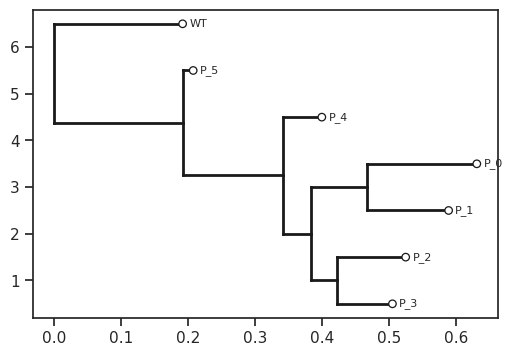

In [350]:
newickPath='../results/K562_tree/trees/grouped_initial.newick'
tree = bt.loadNewick(newickPath)

fig,ax = plt.subplots(figsize=(6,4))

# x_attr=lambda k: k.absoluteTime

tree.plotTree(ax)
tree.plotPoints(ax,size=20,colour='w',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 


**Bootstrap consensus tree**

In [351]:
adata.obs['pop'].unique().to_list()

['P_4', 'P_1', 'P_5', 'P_3', 'P_2', 'P_0']

In [352]:
adata

AnnData object with n_obs × n_vars = 1617 × 7000
    obs: 'pop', 'SNP_count_raw', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo', 'P_5 Features', 'P_4 Features', 'P_3 Features', 'P_2 Features', 'P_1 Features', 'P_0 Features'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor', 'anc', 'der', 'type'
    layers: 'AD', 'DP'

In [353]:
# Resample Sites
pops = adata.obs['pop'].unique().to_list()
pop_sizes = adata.obs['pop'].value_counts().to_dict()
n_bootstraps = 1000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    X_rows = []
    for pop in pops:
        pop_cells = adata[adata.obs['pop'] == pop,]
        n_cells = pop_sizes[pop]
        feature_idx = np.random.choice(np.arange(adata.var.shape[0]), size=adata.var.shape[0], replace=True)
        sampled = pop_cells[:,feature_idx]
        sampled_X = sampled.X
        
        # Take max over axis=0 to get group-level presence/absence vector
        group_vector = sampled_X.max(axis=0)
        X_rows.append(group_vector)

    # append ummutated root
    X_rows.append(np.zeros(adata.n_vars))
    names = pops.copy()
    names.append('WT')
    
    # Stack into dense matrix
    grouped_X = vstack(X_rows).toarray()
    
    # # Optionally: filter variants present in ≥2 populations
    # pop_counts_per_variant = grouped_X.sum(axis=0)
    # keep_mask = pop_counts_per_variant >= 2
    # grouped_X_filtered = grouped_X[:, keep_mask]
    
    # Compute Hamming distances
    pdist = ssd.squareform(ssd.pdist(grouped_X, metric='hamming'))

    # Build NJ tree
    dm = DistanceMatrix(pdist, ids=names)
    tree = nj(dm)
    # tree = nni(tree, dm)
    tree = tree.root_by_outgroup(['WT'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

# # Resample Cells
# pops = adata.obs['pop'].unique().to_list()
# pop_sizes = adata.obs['pop'].value_counts().to_dict()
# n_bootstraps = 1000
# bootstrap_tree_list = dendropy.TreeList()

# for i in tqdm(range(n_bootstraps)):
#     X_rows = []
#     for pop in pops:
#         pop_cells = adata[adata.obs['pop'] == pop,]
#         n_cells = pop_sizes[pop]
#         cell_idx = np.random.choice(np.arange(n_cells), size=500, replace=True)
#         sampled = pop_cells[cell_idx,:]
#         sampled_X = sampled.X
        
#         # Take max over axis=0 to get group-level presence/absence vector
#         group_vector = sampled_X.max(axis=0)
#         X_rows.append(group_vector)
    
#     # append ummutated root
#     X_rows.append(np.zeros(adata.n_vars))
#     names = pops.copy()
#     names.append('WT')
    
#     # Stack into dense matrix
#     grouped_X = vstack(X_rows).toarray()
    
# #     # Optionally: filter variants present in ≥2 populations
# #     pop_counts_per_variant = grouped_X.sum(axis=0)
# #     keep_mask = pop_counts_per_variant >= 2
# #     grouped_X_filtered = grouped_X[:, keep_mask]
    
#     # Compute Hamming distances
#     pdist = ssd.squareform(ssd.pdist(grouped_X, metric='hamming'))

#     # Build NJ tree
#     dm = DistanceMatrix(pdist, ids=names)
#     tree = nj(dm)
#     # tree = nni(tree, dm)
#     tree = tree.root_by_outgroup(['WT'])
    
#     handle = StringIO()
#     tree.write(handle)
#     newick_str = handle.getvalue()
#     t = dendropy.Tree.get(data=newick_str, schema="newick")
#     t.is_rooted = True
#     bootstrap_tree_list.append(t)

# Save trees
bootstrap_tree_list.write(
    path="../results/K562_tree/trees/grouped_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]


In [354]:
!sumtrees --summary-target=mcct --decimals=0 --percentages --output-tree-filepath=../results/K562_tree/trees/grouped_bootstrap_consensus.tre --force-rooted ../results/K562_tree/trees/grouped_bootstrap_trees.tre

/==========================================================================\
|                                 SumTrees                                 |
|                     Phylogenetic Tree Summarization                      |
|                              Version 5.0.1                               |
|                   By Jeet Sukumaran and Mark T. Holder                   |
|                         Using: DendroPy 5.0.1 ()                         |
+--------------------------------------------------------------------------+
|                                 Citation                                 |
|                                 ~~~~~~~~                                 |
| If any stage of your work or analyses relies on code or programs from    |
| this library, either directly or indirectly (e.g., through usage of your |
| own or third-party programs, pipelines, or toolkits which use, rely on,  |
| incorporate, or are otherwise primarily derivative of code/programs in   |

In [355]:
# Load the consensus tree
tree = dendropy.Tree.get(path="../results/K562_tree/trees/grouped_bootstrap_consensus.tre", schema="nexus")

# Write the resolved tree to a new file
tree.write(path="../results/K562_tree/trees/grouped_bootstrap_consensus.newick", schema="newick")

In [356]:
with open("../results/K562_tree/trees/grouped_bootstrap_consensus.tre") as f:
    tree_string = f.read()

# Extract support values and attach them to internal nodes
def extract_supports(tree_string):
    support_pattern = re.compile(r'\)[^\)]*?\[\&support=([0-9.]+)\]')
    supports = [float(s) for s in support_pattern.findall(tree_string)]
    return supports

support_values = extract_supports(tree_string)
support_values = support_values[:-1]  # drop root support val

newickPath='../results/K562_tree/trees/grouped_bootstrap_consensus.newick'
tree = bt.loadNewick(newickPath)

# Attach support values to internal nodes in postorder
internal_nodes = [n for n in tree.Objects if n.is_leaf()==False]
assert len(internal_nodes) == len(support_values), "Support count doesn't match internal nodes"

# Assign support as a trait
for node, support in zip(internal_nodes, support_values):
    node.traits['support'] = support

In [357]:
support_values

[100.0, 100.0, 90.3, 100.0, 100.0, 100.0]

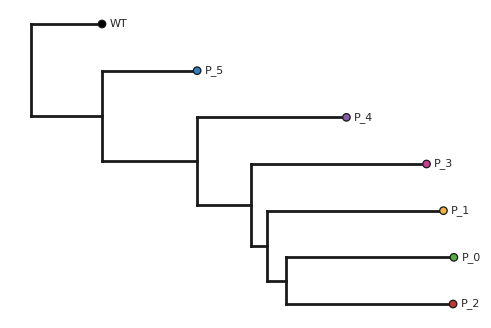

In [358]:
fig,ax = plt.subplots(figsize=(6,4))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[n.name]

tree.plotTree(ax)
tree.plotPoints(ax,size=20,colour=c_func,zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('../results/K562_tree/trees/grouped_consensus_tree_c.png', dpi=600)

## Single Cell Tree Construction

### Test a simple neighbor joining tree

In [132]:
X = adata[:,features].X.toarray()

distance_array = ssd.pdist(X, metric="hamming")
distance_matrix = ssd.squareform(distance_array)

# Build distance matrix and tree
dm = DistanceMatrix(distance_matrix, ids=adata.obs_names.tolist())
tree = nj(dm)
tree = nni(tree, dm)

tree = tree.root_by_outgroup([np.random.choice(adata.obs[adata.obs['pop']=='P_5'].index, 1)[0]])
tree.write('results/sc_test.newick')

'results/sc_test.newick'

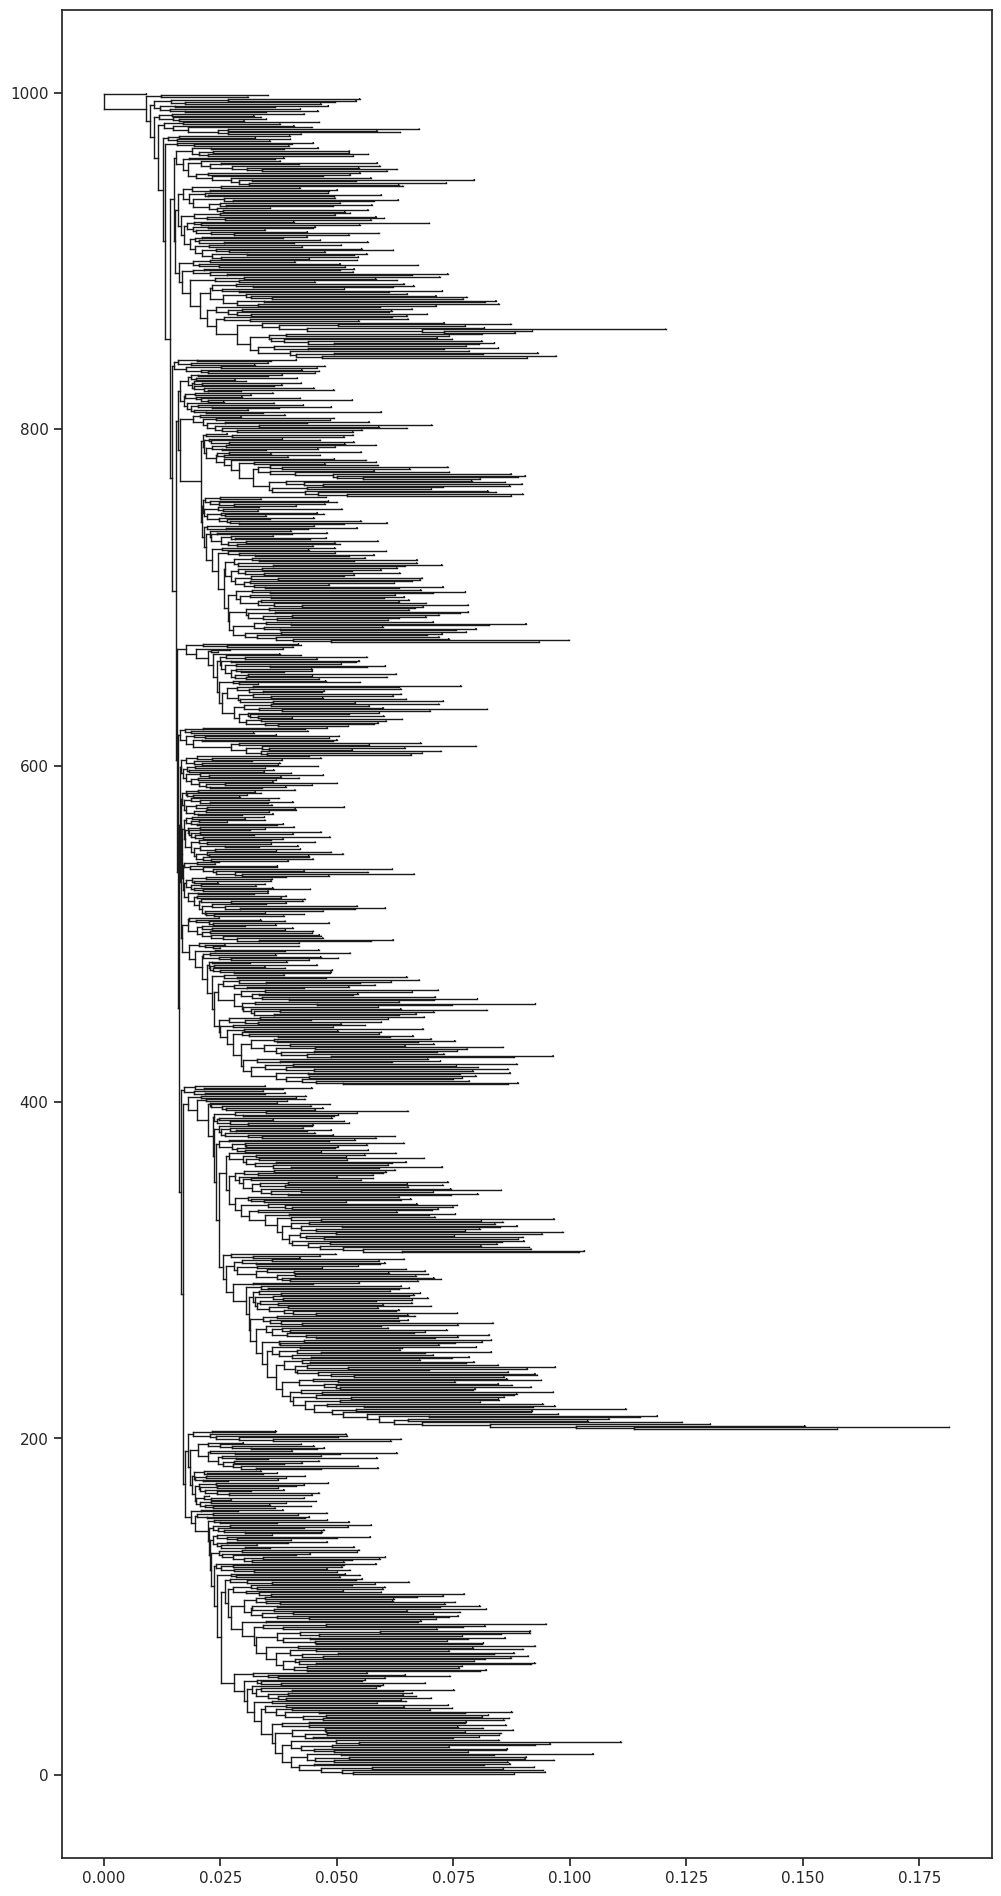

In [134]:
newickPath='results/sc_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]


fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime

tree.plotTree(ax,width=1)
tree.plotPoints(ax,size=0.5,colour='black',
                zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

# tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 
fig.savefig('figures/sc_test_tree.png', dpi=600)

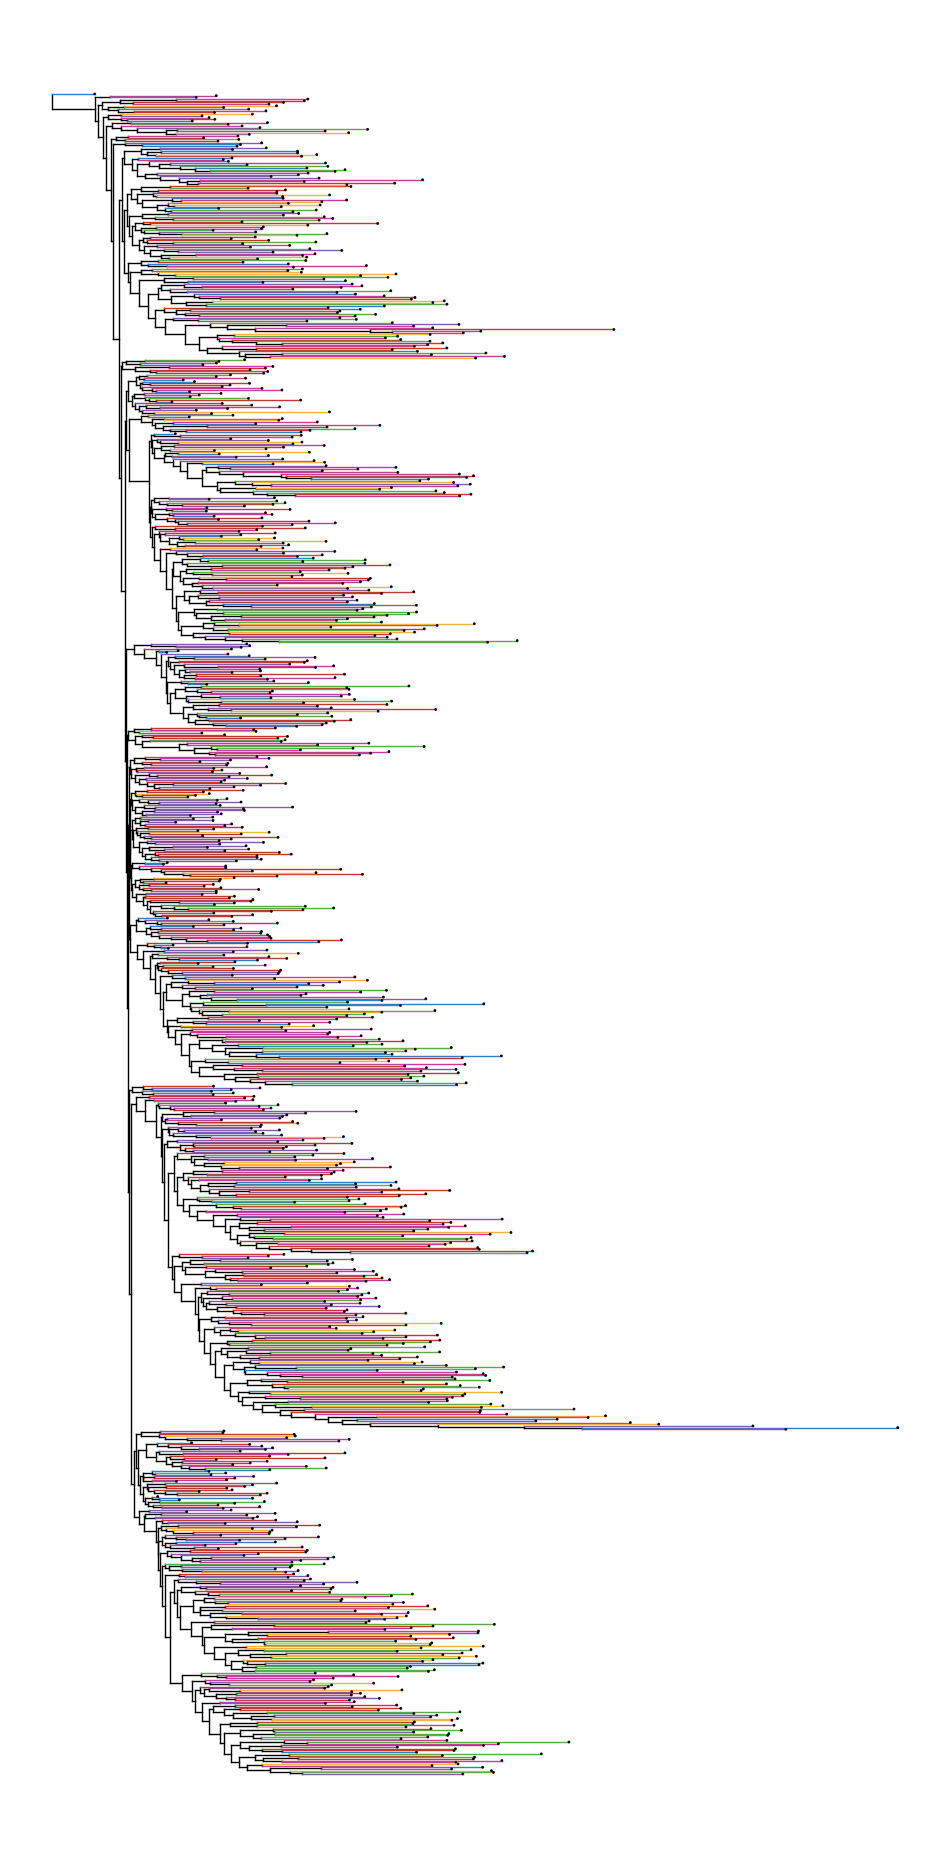

In [155]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_test_tree_c.png', dpi=600)

### Neighbor joining w/ psuedo-unedited cell outgroup

In [106]:
X = adata[:,features].X.toarray()
K562 = np.zeros(len(features))
X = np.append(X, K562.reshape(1, -1), axis=0)
cells = adata.obs_names.to_list()
cells.append('K562')

distance_array = ssd.pdist(X, metric="hamming")
distance_matrix = ssd.squareform(distance_array)

# Build distance matrix and tree
dm = DistanceMatrix(distance_matrix, ids=cells)
tree = nj(dm)
# tree = nni(tree, dm)

tree = tree.root_by_outgroup(['K562'])
tree.write('results/sc_og_test.newick')

'results/sc_og_test.newick'

In [103]:
newickPath='results/sc_og_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

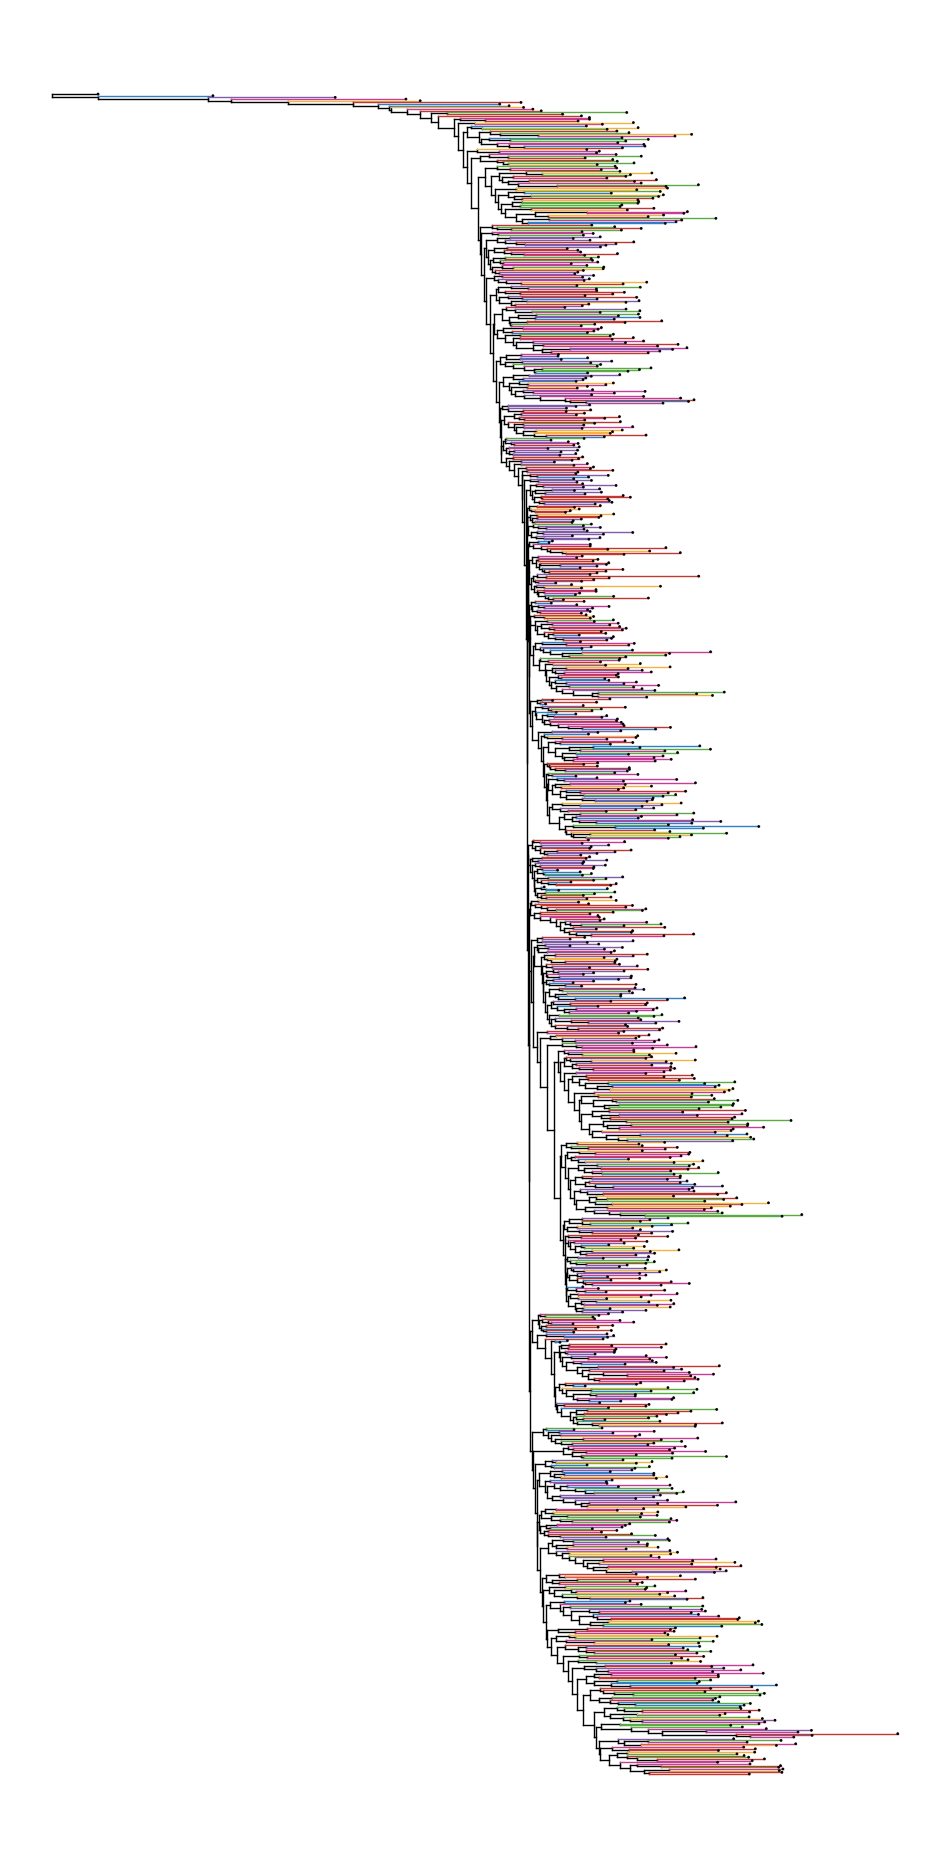

In [104]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() and n.name != 'K562' else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_og_testtree_c.png', dpi=600)

### Neighbor joining w/ bootstrapping and pseudo-unedited cell outgroup

In [112]:
## Odds ratio

n_features = 1000
pop_features = {}
ordered_pops = ['P_5', 'P_4', 'P_3', 'P_2', 'P_1', 'P_0']

features = []
top_all = pd.Series(np.ravel(adata.X.sum(axis=0)), index=adata.var_names).sort_values(ascending=False)[:n_features].index.to_list()
features += top_all
for i, pop in enumerate(ordered_pops):
    pop_cells = adata[adata.obs['pop'] == pop, ~adata.var_names.isin(top_all)]
    pop_X = pop_cells.X
    
    count_with = np.ravel(pop_X.sum(axis=0))
    count_without = pop_cells.n_obs - count_with
    
    # pop_frac = np.ravel(pop_X.sum(axis=0)) / pop_X.shape[0]
    # pop_frac_series = pd.Series(pop_frac, index=adata.var_names)
    
    # pop_frac_series.drop(labels=top_all, errors='ignore')
    
    # top = enrichment.sort_values(ascending=False)[:n_features].index.to_list()
    
    if i == 0:
        # No previous populations to compare against
        count_with_series = pd.Series(count_with, index=pop_cells.var_names)
        top = count_with_series.sort_values(ascending=False)[:n_features].index.to_list()
    else:
        # Combine all previous subpopulations
        prev_pops = ordered_pops[:i]
        prev_cells = adata[adata.obs['pop'].isin(prev_pops), ~adata.var_names.isin(top_all)]
        prev_X = prev_cells.X
        
        prev_count_with = np.ravel(prev_X.sum(axis=0))
        prev_count_without = prev_cells.n_obs - prev_count_with
        
        # Apply 0.5 continuity correction to avoid division by zero
        a = count_with + 0.5
        b = count_without + 0.5
        c = prev_count_with + 0.5
        d = prev_count_without + 0.5

        # Compute odds ratios vectorized
        odds_ratios = (a * d) / (b * c)
        odds_ratios_series = pd.Series(odds_ratios, index=pop_cells.var_names)

        # Rank features most enriched in this population
        top = odds_ratios_series.sort_values(ascending=False)[:n_features].index.to_list()
    
    pop_features[pop] = top
    features += top

In [113]:
n_bootstraps = 1000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    
    feature_idx = np.random.choice(np.arange(len(features)), size=len(features), replace=True)
    sampled = adata[:,feature_idx]
    sampled_X = sampled.X.toarray()
    K562 = np.zeros(len(features))
    sampled_X = np.append(sampled_X, K562.reshape(1, -1), axis=0)
    cells = adata.obs_names.to_list()
    cells.append('K562')
    
    # Compute Hamming distances
    pdist = ssd.squareform(ssd.pdist(sampled_X, metric='hamming'))

    # Build NJ tree
    dm = DistanceMatrix(pdist, ids=cells)
    tree = nj(dm)
    # tree = gme(dm)
    # tree = bme(dm)
    # tree = nni(tree, dm)
    
    tree = tree.root_by_outgroup(['K562'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

100%|██████████| 1000/1000 [39:50<00:00,  2.39s/it] 


In [114]:
bootstrap_tree_list.write(
    path="results/sc_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

# CNV Analysis

In [16]:
cnv = pd.read_csv('AneuFinder_output/result.csv', index_col=0)
cnv.index = cnv['seqnames'].astype(str) + ':' + cnv['start'].astype(str) + '-' + cnv['end'].astype(str)
cnv = cnv.drop(['seqnames', 'start', 'end'], axis=1)
cnv

,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,CGCTAGTTAGGAAACTGCTCACTCTCTGCTTGAAGGGTCGGTAAA,ACTAACCGAGGAAGATGGTCACTCTCTGGAACAAGGGTCCGATTA,GTAATGCCAGGAAGGCTAACACTCGCAATGACAAGGCTGTGAACA,...,GGTCATTGAGGACTGCTCAAACTCGGAACTGTAAGGTTGATGGCA,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA
chr1:1-3000000,1,2,1,2,1,3,2,2,2,3,...,1,2,2,2,2,1,2,2,2,2
chr1:3000001-4000000,1,2,1,2,1,3,2,2,2,3,...,1,2,2,2,2,1,2,2,2,2
chr1:4000001-5000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,2,3,3,2
chr1:5000001-6000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,4,3,3,2
chr1:6000001-7000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,4,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:153000001-156000000,1,2,1,2,1,2,3,2,2,2,...,1,2,2,1,2,1,2,2,1,2
chrY:1-10000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrY:10000001-12000000,0,0,0,0,0,0,2,1,0,0,...,1,0,0,1,0,0,0,0,0,0
chrY:12000001-57000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cnv.median(axis=0).sort_values(ascending=False)

GTGAGACTAGGAAACGATGGACTCAGCATTGGAAGGCGGTTGATA    6.0
CGACAGTAAGGAAACTGCTCACTCGCTGGATAAAGGTGACAGTGA    6.0
GTGTAAGCAGGAAACGATGGACTCAGCATTGGAAGGTGGTCTCAA    6.0
TGTGGTTGAGGAGTCTGCTAACTCCGAACTTGAAGGGACAGCATA    6.0
TGTGGTTGAGGACGCTACTAACTCAGAATGCCAAGGTCCAGGATA    6.0
                                                ... 
AGGTCCAAAGGATTCGGTAGACTCAGGTCGTAAAGGGTGACTCTA    1.0
CGCTAGTTAGGAGGACGAATACTCGGAACTGTAAGGCGGTTGATA    1.0
TATCAGCCAGGAGGACGAATACTCAGGACATCAAGGGTGACTCTA    1.0
GGTCATTGAGGATGGTCACTACTCGGAACTGTAAGGCGACCTATA    0.0
ACCTCGTAAGGAAACGATGGACTCACAGTAGCAAGGGTCGGTAAA    0.0
Length: 1000, dtype: float64

In [37]:
adata.obs['ploidy'] = cnv.mean(axis=0)
# adata.obs.to_csv('results/full_meta.csv')

/loc/scratch/25689862/ipykernel_12588/848181505.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/loc/scratch/25689862/ipykernel_12588/848181505.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


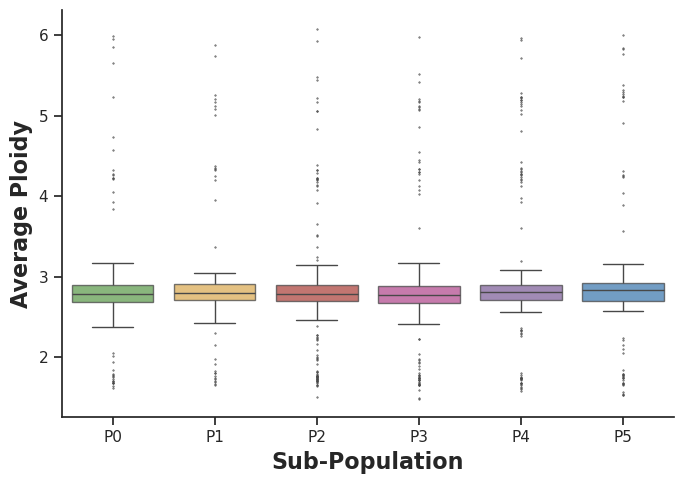

In [43]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(
    data=adata.obs,
    x='pop',
    y='ploidy',
    palette=pal,
    fliersize=0.5
)
# ax.set_xscale('log')
for patch in ax.patches:
    patch.set_alpha(0.75) 
# plt.ylim(0,4)
plt.ylabel('Average Ploidy', fontweight='bold', fontsize=16)
plt.xlabel('Sub-Population', fontweight='bold', fontsize=16)

new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_xticklabels(new_labels)

plt.tight_layout()
# f.savefig('figures/SNPs_per_cell.png', dpi=600, bbox_inches='tight')

<Axes: xlabel='ploidy', ylabel='Count'>

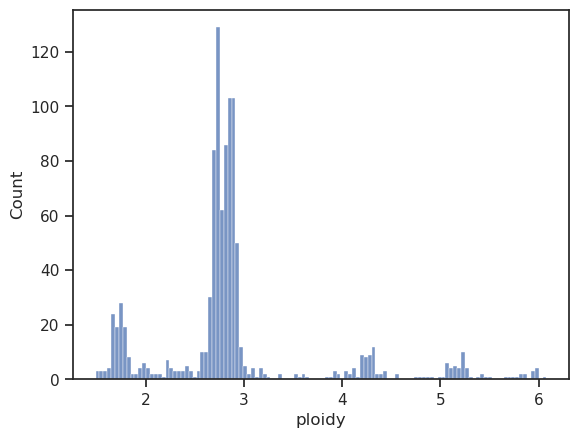

In [122]:
sns.histplot(adata.obs,
             x='ploidy',
            )

In [123]:
adata.obs['ploidy'].median()

np.float64(2.799147442326981)

In [129]:
adata.obs[adata.obs['ploidy']<2.5].shape[0]

165

In [144]:
count = adata.obs[(adata.obs['ploidy']>=2.5) & (adata.obs['ploidy']<3.5)].shape[0]
av_ploidy = adata.obs[(adata.obs['ploidy']>=2.5) & (adata.obs['ploidy']<3.5)]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

70.3% of cells have avg ploidy: 2.80685941180583


In [142]:
count = adata.obs[(adata.obs['ploidy']>=3.5) & (adata.obs['ploidy']<4.5)].shape[0]
av_ploidy = adata.obs[(adata.obs['ploidy']>=3.5) & (adata.obs['ploidy']<4.5)]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

6.800000000000001% of cells have avg ploidy: 4.1572511652604875


In [143]:
count = adata.obs[adata.obs['ploidy']>=4.5].shape[0]
av_ploidy = adata.obs[adata.obs['ploidy']>=4.5]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

6.4% of cells have avg ploidy: 5.323243167001003


### Comparison with K562 ref

In [212]:
cnv = pd.read_csv('AneuFinder_output/result.csv', index_col=0)
cnv.rename(columns={'seqnames':'Chromosome','start':'Start','end':'End'}, inplace=True)
cnv

,Chromosome,Start,End,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,...,GGTCATTGAGGACTGCTCAAACTCGGAACTGTAAGGTTGATGGCA,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA
1,chr1,1,3000000,1,2,1,2,1,3,2,...,1,2,2,2,2,1,2,2,2,2
2,chr1,3000001,4000000,1,2,1,2,1,3,2,...,1,2,2,2,2,1,2,2,2,2
3,chr1,4000001,5000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,2,3,3,2
4,chr1,5000001,6000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,4,3,3,2
5,chr1,6000001,7000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,4,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,chrX,153000001,156000000,1,2,1,2,1,2,3,...,1,2,2,1,2,1,2,2,1,2
1991,chrY,1,10000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,chrY,10000001,12000000,0,0,0,0,0,0,2,...,1,0,0,1,0,0,0,0,0,0
1993,chrY,12000001,57000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
ref = pd.read_csv('K562_ref_ploidy_hg38.bed', sep='\t', header=None)
ref.columns = ['Chromosome', 'Start', 'End', 'Ploidy']
ref

,Chromosome,Start,End,Ploidy
0,chr1,10000,54799327,4
1,chr1,54799327,106777378,3
2,chr1,106777378,121743636,4
3,chr1,143822875,162380210,3
4,chr1,162380210,248744909,4
...,...,...,...,...
56,chr19,60000,58607616,3
57,chr20,79359,26338933,2
58,chr20,30184893,64334167,3
59,chr21,24127687,46699983,4


In [214]:
ref['Ploidy'].mean()

np.float64(2.8524590163934427)

In [215]:
# Create PyRanges for bins and reference
bins_pr = pr.PyRanges(cnv[['Chromosome', 'Start', 'End']])
ref_pr = pr.PyRanges(ref[['Chromosome', 'Start', 'End', 'Ploidy']])

In [216]:
# Map each bin to overlapping reference region
joined = bins_pr.join(ref_pr)

# Convert back to DataFrame and merge with original CNV values
joined_df = joined.as_df()
joined_df

,Chromosome,Start,End,Start_b,End_b,Ploidy
0,chr1,1,3000000,10000,54799327,4
1,chr1,3000001,4000000,10000,54799327,4
2,chr1,4000001,5000000,10000,54799327,4
3,chr1,5000001,6000000,10000,54799327,4
4,chr1,6000001,7000000,10000,54799327,4
...,...,...,...,...,...,...
1931,chrX,149000001,150000000,10000,156030895,2
1932,chrX,150000001,151000000,10000,156030895,2
1933,chrX,151000001,152000000,10000,156030895,2
1934,chrX,152000001,153000000,10000,156030895,2


In [217]:
cnv = cnv.merge(
    joined_df[['Chromosome', 'Start', 'End', 'Ploidy']],
    on=['Chromosome', 'Start', 'End'],
    how='left'  # important!
)
cnv.rename(columns={'Ploidy':'K562_ref'}, inplace=True)
cnv = cnv.fillna(3)
cnv['K562_ref'] = cnv['K562_ref'].astype(int)
cnv

,Chromosome,Start,End,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,...,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA,K562_ref
0,chr1,1,3000000,1,2,1,2,1,3,2,...,2,2,2,2,1,2,2,2,2,4
1,chr1,3000001,4000000,1,2,1,2,1,3,2,...,2,2,2,2,1,2,2,2,2,4
2,chr1,4000001,5000000,2,2,2,2,3,3,2,...,2,4,2,2,2,2,3,3,2,4
3,chr1,5000001,6000000,2,2,2,2,3,3,2,...,2,4,2,2,2,4,3,3,2,4
4,chr1,6000001,7000000,2,2,2,2,3,3,2,...,2,4,2,2,2,4,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,chrX,153000001,156000000,1,2,1,2,1,2,3,...,2,2,1,2,1,2,2,1,2,2
2021,chrY,1,10000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2022,chrY,10000001,12000000,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,3
2023,chrY,12000001,57000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [222]:
# Identify cell columns (excluding coord + reference)
non_cell_cols = ['Chromosome', 'Start', 'End', 'K562_ref']
cell_cols = [col for col in cnv.columns if col not in non_cell_cols]

# Create matrix for cells and reference
cell_matrix = cnv[cell_cols]
ref_vector = cnv['K562_ref']


In [223]:
# Mean absolute difference per cell
mean_abs_diff = cell_matrix.sub(ref_vector, axis=0).abs().mean()

# Pearson correlation per cell
pearson_corr = cell_matrix.corrwith(ref_vector)

In [226]:
summary_df = pd.DataFrame({
    'Avg_Ploidy': adata.obs['ploidy'],
    'MeanAbsDiff': mean_abs_diff.values,
    'PearsonCorrelation': pearson_corr.values
})

In [227]:
summary_df

,Avg_Ploidy,MeanAbsDiff,PearsonCorrelation
GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,1.733701,1.305185,0.654552
CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,2.820461,0.713086,0.487912
GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,1.751755,1.286914,0.647618
ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,2.905717,0.210864,0.711136
CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,2.718656,0.367901,0.647837
...,...,...,...
TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,1.830993,1.213333,0.663381
CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,2.883149,0.233580,0.692488
GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,2.795386,0.372840,0.652743
AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,3.004012,0.443951,0.689641


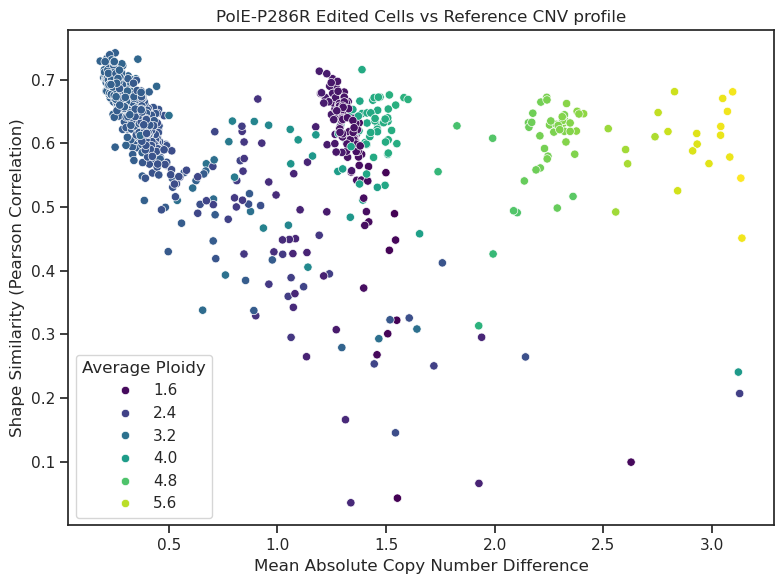

In [235]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary_df,
                x='MeanAbsDiff',
                y='PearsonCorrelation', 
                hue='Avg_Ploidy',
                palette='viridis'
               )
plt.xlabel('Mean Absolute Copy Number Difference')
plt.ylabel('Shape Similarity (Pearson Correlation)')
plt.title('PolE-P286R Edited Cells vs Reference CNV profile')
plt.legend(title='Average Ploidy')
plt.tight_layout()
plt.show()

In [240]:
mean_rho = pearson_corr.mean()
std_rho = pearson_corr.std()
print(f'mean rho = {mean_rho:.2f}')
print(f'standard deviation = {std_rho:.2f}')

mean rho = 0.62
standard deviation = 0.09


In [258]:
## Generate permutation based null
def shuffled_corr(ref_vector, cell_matrix, n_permutations=1000, seed=42):
    np.random.seed(seed)
    shuffled_corrs = []
    for _ in tqdm(range(n_permutations)):
        shuffled_ref = ref_vector.sample(frac=1, replace=False).reset_index(drop=True)
        cell_corrs = cell_matrix.corrwith(shuffled_ref)
        shuffled_corrs.append(cell_corrs.mean())
    return np.array(shuffled_corrs)

In [259]:
mean_rho = pearson_corr.mean()
null_corrs = shuffled_corr(ref_vector, cell_matrix, n_permutations=1000)

# One-sided p-value: are real correlations significantly higher than null?
empirical_p = np.mean(null_corrs >= mean_rho)

100%|██████████| 1000/1000 [15:18<00:00,  1.09it/s]


In [260]:
empirical_p

np.float64(0.0)

### Neighbor Joining tree from CNV data

**TODO**: outgroup rooting with "normal K562" CNV profile

In [266]:
tree_matrix = cell_matrix
tree_matrix['K562'] = ref_vector

/loc/scratch/25689862/ipykernel_12588/4058833123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_matrix['K562'] = ref_vector


In [267]:
## Pearson Correlation
corr_matrix = tree_matrix.corr()
distance_matrix = 1 - corr_matrix
distance_matrix = ssd.squareform(distance_matrix)

In [269]:
dm = DistanceMatrix(distance_matrix, ids=tree_matrix.columns.to_list())
tree = nj(dm)
tree = nni(tree, dm)

tree = tree.root_by_outgroup(['K562'])
tree.write('results/cnv_sc_test.newick')

'results/cnv_sc_test.newick'

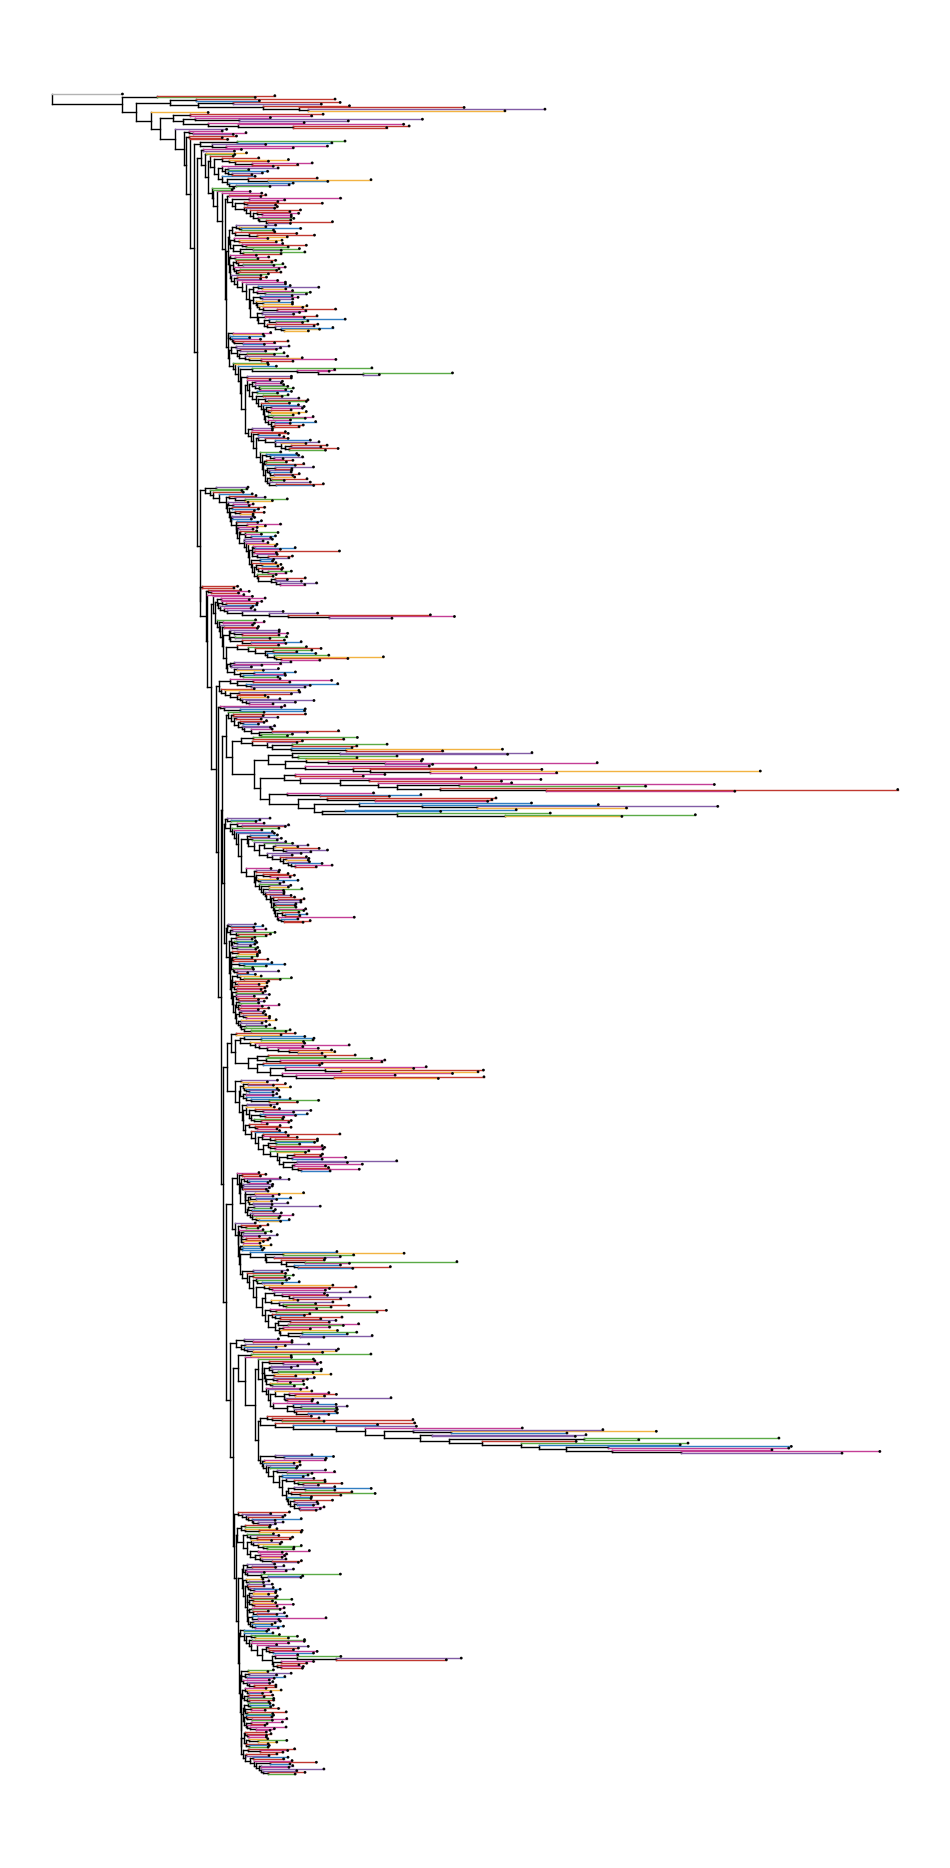

In [270]:
newickPath='results/cnv_sc_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/cnv_sc_test_tree_c.png', dpi=600)

### CNV Tree with bootstrapping

In [274]:
tree_matrix.shape[0]

2025

In [275]:
n_bootstraps = 1000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    
    feature_idx = np.random.choice(np.arange(tree_matrix.shape[0]), size=tree_matrix.shape[0], replace=True)
    sampled = tree_matrix.iloc[feature_idx]
    sampled_X = sampled.values
    
    corr_matrix = tree_matrix.corr()
    distance_matrix = 1 - corr_matrix
    distance_matrix = ssd.squareform(distance_matrix)

    # Build NJ tree
    dm = DistanceMatrix(distance_matrix, ids=tree_matrix.columns.to_list())
    tree = nj(dm)
    # tree = gme(dm)
    # tree = bme(dm)
    # tree = nni(tree, dm)
    
    tree = tree.root_by_outgroup(['K562'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

100%|██████████| 1000/1000 [1:14:40<00:00,  4.48s/it]


In [276]:
bootstrap_tree_list.write(
    path="results/sc_cnv_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

# Final Consensus tree

In [ ]:
## Combine bootstrap lists


In [115]:
!sumtrees --decimals=0 -s mcct --percentages --output-tree-filepath=results/sc_bootstrap_consensus.tre --force-rooted results/sc_bootstrap_trees.tre

/==========================================================================\
|                                 SumTrees                                 |
|                     Phylogenetic Tree Summarization                      |
|                              Version 5.0.1                               |
|                   By Jeet Sukumaran and Mark T. Holder                   |
|                         Using: DendroPy 5.0.1 ()                         |
+--------------------------------------------------------------------------+
|                                 Citation                                 |
|                                 ~~~~~~~~                                 |
| If any stage of your work or analyses relies on code or programs from    |
| this library, either directly or indirectly (e.g., through usage of your |
| own or third-party programs, pipelines, or toolkits which use, rely on,  |
| incorporate, or are otherwise primarily derivative of code/programs in   |

In [116]:
# Load the consensus tree
tree = dendropy.Tree.get(path="results/sc_bootstrap_consensus.tre", schema="nexus")

# Write the resolved tree to a new file
tree.write(path="results/sc_bootstrap_consensus.newick", schema="newick")

In [117]:
newickPath='results/sc_bootstrap_consensus.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

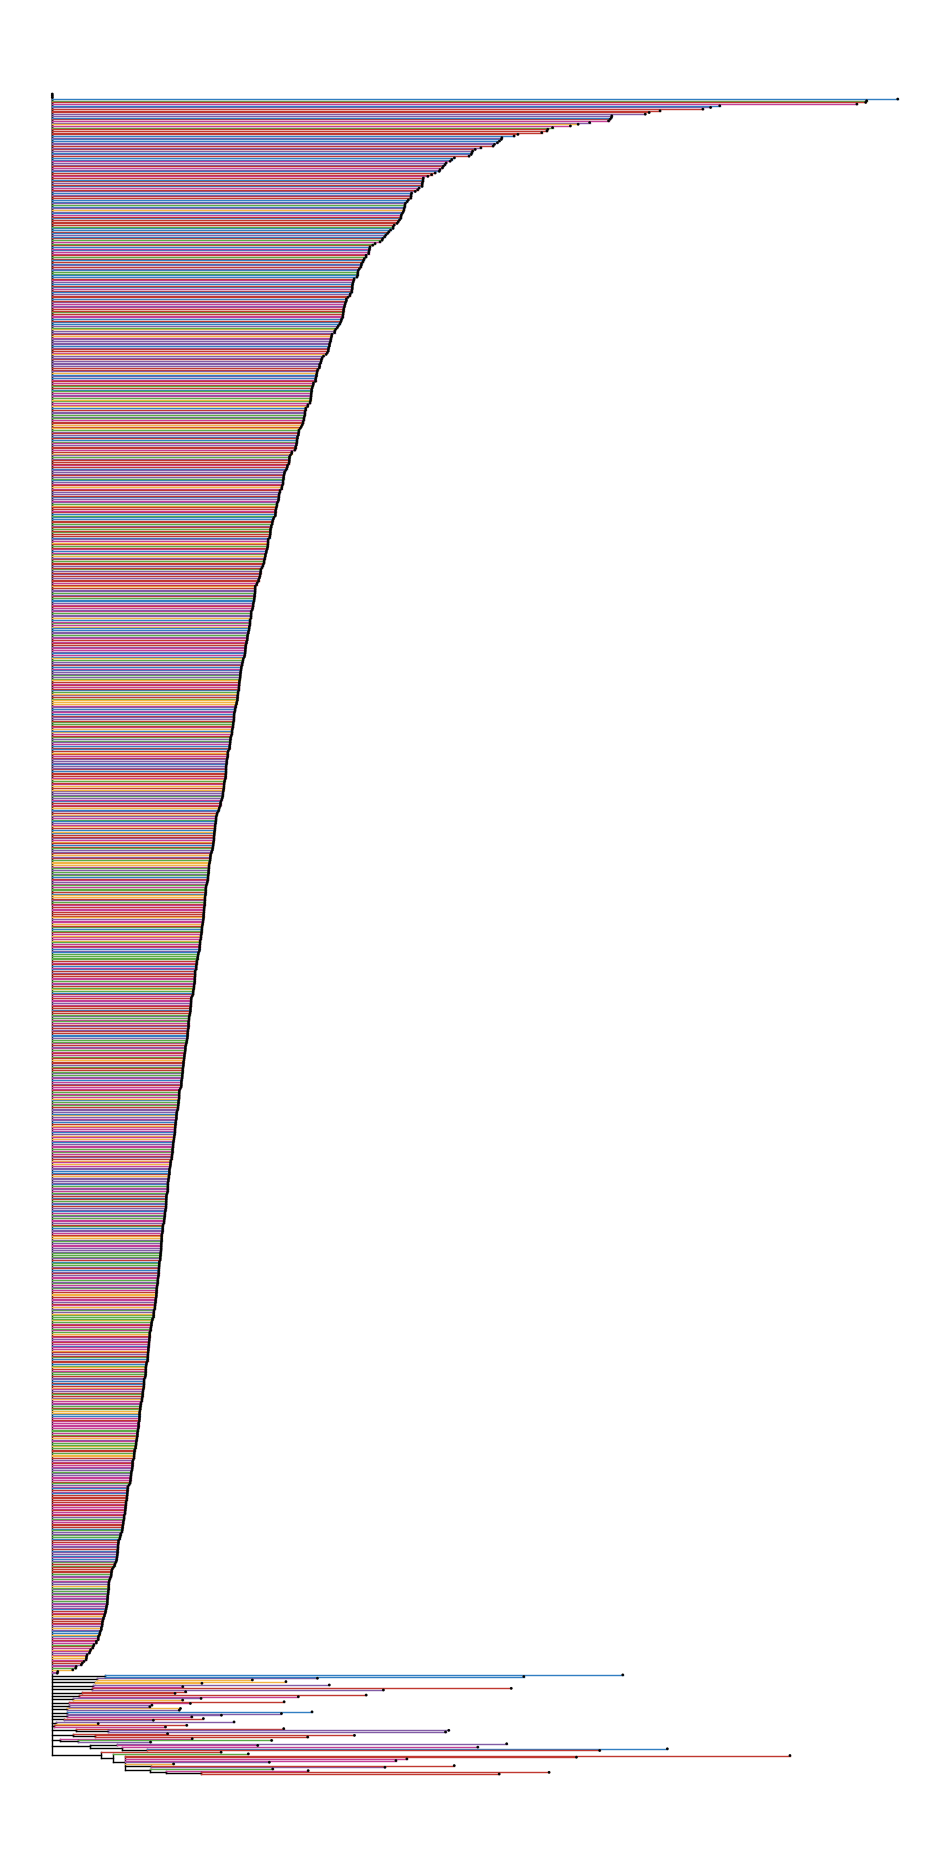

In [ ]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() and n.name != 'K562' else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_bs_tree.png', dpi=600)